In [1]:
"""from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/Nlp.version1/')"""

"from google.colab import drive\ndrive.mount('/content/drive')\nimport sys\nsys.path.append('/content/drive/MyDrive/Nlp.version1/')"

In [2]:
"""# CatBoost kütüphanesini yüklemek için
!pip install catboost

# XGBoost kütüphanesini yüklemek için
!pip install xgboost

# Imbalanced-learn kütüphanesini yüklemek için (SMOTE, RandomOverSampler, RandomUnderSampler kullanmak için)
!pip install imbalanced-learn

# scikit-learn kütüphanesini yüklemek için
!pip install scikit-learn==1.4.2

!pip install numpy==1.26.4
# Pandas kütüphanesini yüklemek için
!pip install pandas

# Matplotlib kütüphanesini yüklemek için
!pip install matplotlib

# PyTorch kütüphanesini yüklemek için
!pip install torch

!pip  install openpyxl
!pip install imbalanced-learn"""

'# CatBoost kütüphanesini yüklemek için\n!pip install catboost\n\n# XGBoost kütüphanesini yüklemek için\n!pip install xgboost\n\n# Imbalanced-learn kütüphanesini yüklemek için (SMOTE, RandomOverSampler, RandomUnderSampler kullanmak için)\n!pip install imbalanced-learn\n\n# scikit-learn kütüphanesini yüklemek için\n!pip install scikit-learn==1.4.2\n\n!pip install numpy==1.26.4\n# Pandas kütüphanesini yüklemek için\n!pip install pandas\n\n# Matplotlib kütüphanesini yüklemek için\n!pip install matplotlib\n\n# PyTorch kütüphanesini yüklemek için\n!pip install torch\n\n!pip  install openpyxl\n!pip install imbalanced-learn'

In [3]:
import warnings
warnings.filterwarnings('ignore')
import sklearn
print(sklearn.__version__)

import numpy as np
print(np.__version__)

import pandas as pd
print(pd.__version__)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import train_test_split
from collections import Counter

import xgboost as xgb
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier
from catboost import CatBoostClassifier

from gensim.models import Word2Vec
import gensim
print(gensim.__version__)

1.4.2
1.26.4
2.2.2
4.3.3


In [4]:
from functions.function import model_training
from functions.dataSampling import makeVector, turkishWord2Vec
from functions.monitoring import print_system_memory_info,clear_memory
from functions.general_graphic_visualization import visualize_data_splits
from functions.plots import plot_conclusion
from functions.ml_model import evaluate_multiple_models

In [5]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    gpu_name = torch.cuda.get_device_name(0)
    vram_total = torch.cuda.get_device_properties(device).total_memory
    vram_total_gb = vram_total / (1024 ** 3)  # Convert bytes to GB
    
    print(f"GPU 0 Device Name: {gpu_name}")
    print(f"Total VRAM on GPU 0: {vram_total_gb:.2f} GB")
else:
    print("No GPU available")


GPU 0 Device Name: NVIDIA GeForce RTX 4060 Laptop GPU
Total VRAM on GPU 0: 8.00 GB


In [6]:
print("It's alive! It's alive! It's alive!")

It's alive! It's alive! It's alive!


In [7]:
clear_memory()
print_system_memory_info()

Cleared memory.
now memory used: 560.67 MB
Total RAM: 33.62 GB
Available RAM: 24.74 GB
Used RAM: 8.88 GB
RAM Usage: 26.4%

An error occurred while retrieving disk usage information:
argument 1 (impossible<bad format char>)
Total GPU Memory: 8.59 GB
Used GPU Memory: 0.26 GB
Free GPU Memory: 8.33 GB


# Load dataset

In [9]:
# Try to load the dataset
try:
    # Load data from an Excel file
    data = pd.read_csv("HateSpeechTurkish.csv")
except Exception as e:
    print(f"Dönüştürme sırasında bir hata oluştu: {e}")
    # Fallback: You can load a CSV file if the Excel file isn't available
    # Uncomment the line below if you have a backup CSV file
    # data = pd.read_csv("data_Llama.csv")
    #/content/drive/MyDrive/Nlp.version1/


In [10]:
if data.isnull().values.any():
    print(data.isnull().sum())
    data.dropna(inplace=True)
    print("After drop null value:")
print(data.isnull().sum())

row_id                      0
tweet                       0
etiket                     55
corrected_tweet             0
correct_normalize_tweet     0
dtype: int64
After drop null value:
row_id                     0
tweet                      0
etiket                     0
corrected_tweet            0
correct_normalize_tweet    0
dtype: int64


In [11]:
# Retain only the relevant columns: 'tweet' and 'etiket'
data = data[["correct_normalize_tweet","etiket"]]

# Separate tweets and labels
tweets = data['correct_normalize_tweet']
labels = data["etiket"]

In [12]:
# Print the label distribution for inspection
print("Label distribution:")
print(labels.value_counts())

Label distribution:
etiket
hiçbiri      7667
nefret       2336
saldırgan     166
Name: count, dtype: int64


In [13]:
tweets.head(10)

0    orospum çocukları hepimiz aynı anda yazıyorsun...
1    ciddiye olan dünyanın beynin bileyim iki günü ...
2    kayıtlı geniş programında göre şimdilik bursa ...
3    hastaneye ait suriye'yi ptt ve ait suriye'yi p...
4                kölesi gitmiş suriye'yi gibiyim bugün
5    çocuklar sadece türkiye değil ırak suriye terö...
6                      suriye'yi olduğumuzu biliyorduk
7    keşke sadece suriye'yi çalıştıran işveren teşv...
8    izin suriye'yi afgan pakistan'ı politikanız no...
9         ülkede büyükelçi dahil suriye'yi istemiyoruz
Name: correct_normalize_tweet, dtype: object

In [14]:
labels.head(10)

0       nefret
1    saldırgan
2      hiçbiri
3       nefret
4      hiçbiri
5      hiçbiri
6      hiçbiri
7      hiçbiri
8      hiçbiri
9       nefret
Name: etiket, dtype: object

In [15]:
print("Original data class distribution:", Counter(labels))

Original data class distribution: Counter({'hiçbiri': 7667, 'nefret': 2336, 'saldırgan': 166})


In [16]:
# Calculate class distribution with Counter
class_distribution = Counter(labels)

# Total number of data points
total_count = sum(class_distribution.values())

# Calculate and display percentage distribution
print("Original data class distribution:")
for label, count in class_distribution.items():
    percentage = (count / total_count) * 100
    print(f"{label}: {count} instances ({percentage:.2f}%)")

Original data class distribution:
nefret: 2336 instances (22.97%)
saldırgan: 166 instances (1.63%)
hiçbiri: 7667 instances (75.40%)


# 📈 ML - Models ✨--------------------------------------------------------------------------------------

In [18]:
xgb_model = xgb.XGBClassifier(tree_method='gpu_hist',max_depth=6, gpu_id=0, random_state=42, use_label_encoder=False,  n_estimators=50)
catB_model = CatBoostClassifier(iterations=50, learning_rate=0.1, depth=4, verbose=0,)# (XGBoost ve CatBoost)
ann_mlpc_sgd = MLPClassifier(solver='sgd', alpha=1e-5, activation='relu',  hidden_layer_sizes=(20, 10, 5),max_iter=50, learning_rate='adaptive', random_state=7)# MLPClassifier (Yapay Sinir Ağı Sınıflandırıcı)
extraTC = ExtraTreesClassifier(n_estimators=100, random_state=7)# ExtraTreesClassifier (Ekstra Karar Ağaçları)

In [19]:
modelsAndNames =   [
    ('CatBoostC', catB_model),
       ('XGBoost', xgb_model),
       ('MLPC-sgd', ann_mlpc_sgd),
       ('ExtraTreesC', extraTC),
       
   ]

# Converting categorical labels to numerical data

In [21]:
label_mapping = {'nefret': 1, 'hiçbiri': 0, 'saldırgan': 2}
labels = data['etiket'].map(label_mapping)

#for saving result
result_dic ={}

len_labels = len(set(labels)) #for num_classes

# Splitting the data into training and test sets

In [23]:
X_train, X_test, y_train, y_test = train_test_split(tweets, labels, test_size=0.2, random_state=42)
dataset_names = ["labels","y_train","y_test"]

In [24]:
print(y_train.value_counts())

etiket
0    6133
1    1865
2     137
Name: count, dtype: int64


In [25]:
print(y_test.value_counts())

etiket
0    1534
1     471
2      29
Name: count, dtype: int64


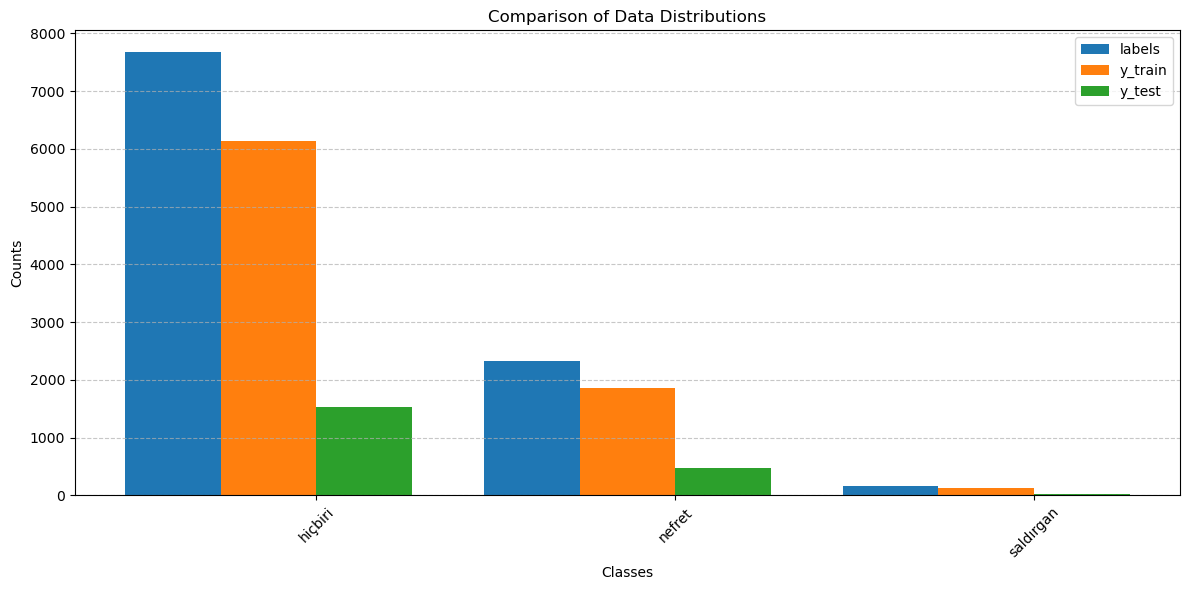

In [26]:
visualize_data_splits(
    labels, y_train, y_test,
    label_mapping=label_mapping
    ,dataset_names=dataset_names
)

# Word2Vec and Fine-Tune Word2Vec

In [28]:
results_df = pd.DataFrame(columns=['Model', 'Vectorization Method', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

## Turkish Word2Vec

In [30]:
%%time
X_train_wv,X_test_wv,y_train_wv,y_test_wv = turkishWord2Vec(X_train,X_test,y_train,y_test,model_type ='basic')

Word2Vec conversion is performed for X_train...
Word2Vec conversion is performed for X_test...
X_train_wv shape: (8135, 400)
X_test_wv shape: (2034, 400)
Before sampling Counter({0: 6133, 1: 1865, 2: 137})
After sampling Counter({0: 6133, 1: 6133, 2: 6133})
x_train_smote shape: (18399, 400), y_train_smote shape: (18399,)
CPU times: total: 4.55 s
Wall time: 4.66 s


In [31]:
non_zero_count = np.count_nonzero(X_train_wv)

print(f"There are {non_zero_count} non-zero values in the dataset.")
print(f"X_train_wv frist 5 element: {X_train_wv[:5]}")

There are 7357200 non-zero values in the dataset.
X_train_wv frist 5 element: [[ 0.10368568 -0.62153059 -0.67144656 ...  0.23191378 -0.89813769
  -0.08405878]
 [ 0.26813367 -0.99008805 -0.09259826 ...  0.30700395 -0.9356513
  -0.48163435]
 [ 0.98938364  0.23249684 -0.83138752 ...  0.48195022 -1.36261749
  -0.63809079]
 [ 0.53428668 -0.56434774 -0.72641706 ...  0.65178931 -0.59853834
  -0.23418149]
 [ 0.53508317 -0.28904948 -0.21274343 ...  0.50057334 -0.36857972
  -0.31465098]]


CatBoostError: catboost/libs/data/quantization.cpp:2420: All features are either constant or ignored.
I could not solve this error with normalize or scaler.
The error is caused by the Word2Vec model being loaded correctly but being given the wrong input.


Evaluating CatBoostC...
Model Evaluation: CatBoostC
F1 Score: 0.66494 | Accuracy: 0.62979 | Precision: 0.71625 | Recall: 0.62979 | Training Accuracy: 0.70640 | Validation Accuracy: 0.62979


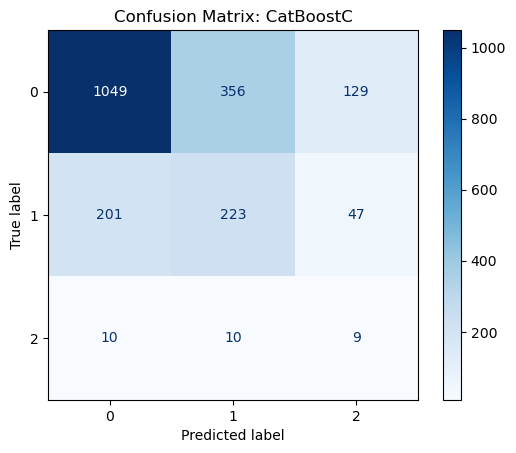

Model saved at: ml_model\ml_CatBoostC_TurkishWord2Vec.joblib

Evaluating XGBoost...
Model Evaluation: XGBoost
F1 Score: 0.75730 | Accuracy: 0.76696 | Precision: 0.74974 | Recall: 0.76696 | Training Accuracy: 0.91364 | Validation Accuracy: 0.76696


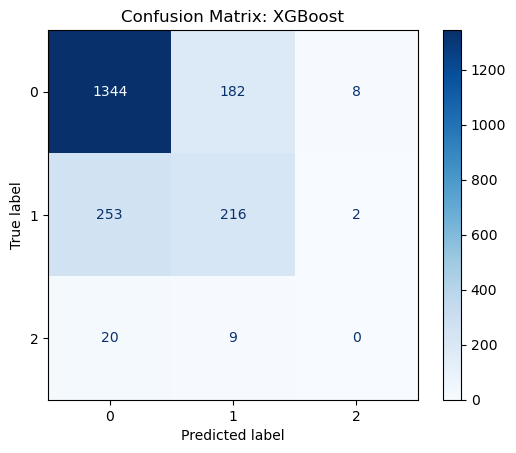

Model saved at: ml_model\ml_XGBoost_TurkishWord2Vec.joblib

Evaluating MLPC-sgd...
Model Evaluation: MLPC-sgd
F1 Score: 0.74114 | Accuracy: 0.72566 | Precision: 0.76782 | Recall: 0.72566 | Training Accuracy: 0.79825 | Validation Accuracy: 0.72566


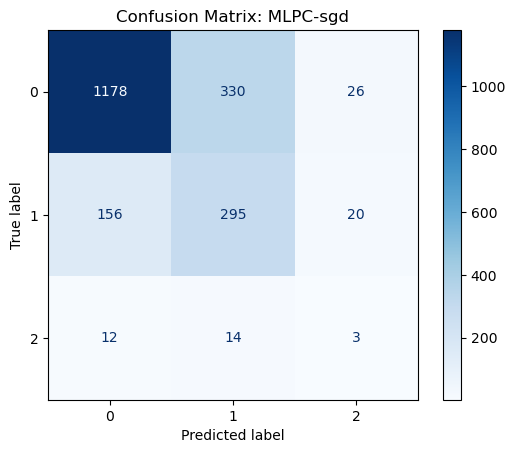

Model saved at: ml_model\ml_MLPC-sgd_TurkishWord2Vec.joblib

Evaluating ExtraTreesC...
Model Evaluation: ExtraTreesC
F1 Score: 0.73517 | Accuracy: 0.77040 | Precision: 0.73059 | Recall: 0.77040 | Training Accuracy: 0.94098 | Validation Accuracy: 0.77040


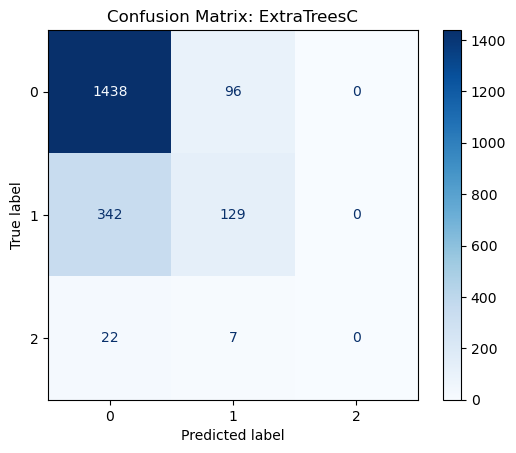

Model saved at: ml_model\ml_ExtraTreesC_TurkishWord2Vec.joblib
CPU times: total: 1min 18s
Wall time: 39.1 s


In [33]:
%%time
df_W2v_ml = evaluate_multiple_models(
    X_train_wv,X_test_wv,
    y_train_wv,y_test_wv,
    modelsAndNames,
    vectorization_method="TurkishWord2Vec"
)

In [34]:
results_df = pd.concat([results_df, df_W2v_ml], ignore_index=True)


TurkishWord2Vec:
Epoch [1/50], Train Loss: 1.0360, Train Accuracy: 0.5155, Validation Loss: 1.3199, Validation Accuracy: 0.2316
Epoch [2/50], Train Loss: 1.2181, Train Accuracy: 0.3333, Validation Loss: 1.3199, Validation Accuracy: 0.2316
Epoch [3/50], Train Loss: 1.2181, Train Accuracy: 0.3333, Validation Loss: 1.3199, Validation Accuracy: 0.2316
Epoch [4/50], Train Loss: 1.2181, Train Accuracy: 0.3333, Validation Loss: 1.3199, Validation Accuracy: 0.2316
Epoch [5/50], Train Loss: 1.2724, Train Accuracy: 0.2792, Validation Loss: 1.3199, Validation Accuracy: 0.2316
Epoch [6/50], Train Loss: 1.2390, Train Accuracy: 0.3122, Validation Loss: 1.3199, Validation Accuracy: 0.2316
Epoch [7/50], Train Loss: 1.0133, Train Accuracy: 0.5381, Validation Loss: 1.3197, Validation Accuracy: 0.2316
Epoch [8/50], Train Loss: 0.9985, Train Accuracy: 0.5523, Validation Loss: 1.3199, Validation Accuracy: 0.2316
Epoch [9/50], Train Loss: 0.9765, Train Accuracy: 0.5866, Validation Loss: 1.5134, Validation 

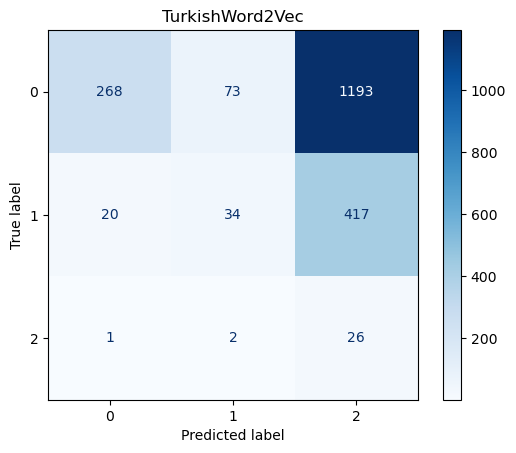

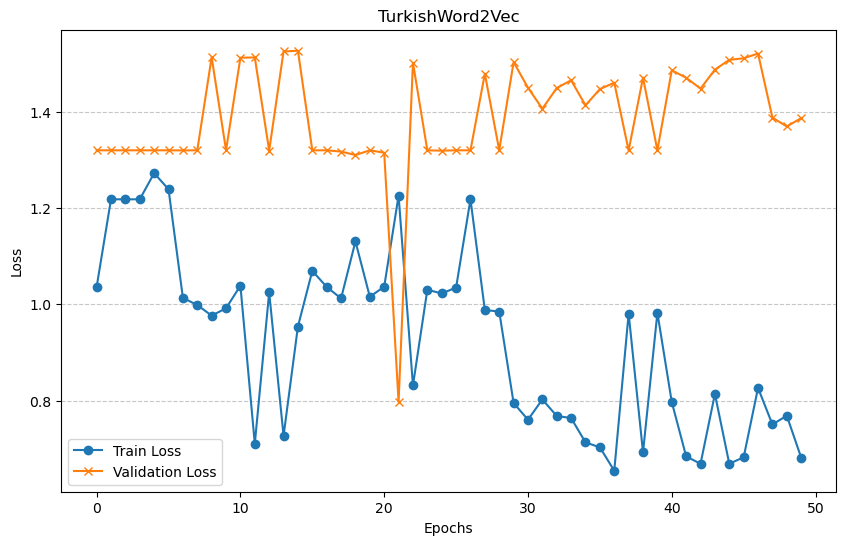

Model saved to models/TurkishWord2Vec_ANN.pth
Results saved to models/TurkishWord2Vec_results.csv
CPU times: total: 51 s
Wall time: 16min 48s


In [35]:
%%time
df_W2V = model_training("TurkishWord2Vec",X_train_wv,X_test_wv,y_train_wv,y_test_wv,len_labels)

In [36]:
results_df = pd.concat([results_df, df_W2V], ignore_index=True)

In [37]:
results_df

,Model,Vectorization Method,Accuracy,Precision,Recall,F1 Score
0,CatBoostC,TurkishWord2Vec,0.629794,0.716249,0.629794,0.664940
1,XGBoost,TurkishWord2Vec,0.766962,0.749744,0.766962,0.757297
2,MLPC-sgd,TurkishWord2Vec,0.725664,0.767823,0.725664,0.741140
3,ExtraTreesC,TurkishWord2Vec,0.770403,0.730594,0.770403,0.735169
4,ANN,TurkishWord2Vec,0.161259,0.771834,0.161259,0.249338


## Fine-Tune Turkish Word2Vec

In [39]:
X_train_Ft,X_test_Ft,y_train_Ft,y_test_Ft = turkishWord2Vec(X_train,X_test,y_train,y_test,model_type = 'finetune' )

Word2Vec conversion is performed for X_train...
Word2Vec conversion is performed for X_test...
X_train_wv shape: (8135, 400)
X_test_wv shape: (2034, 400)
Before sampling Counter({0: 6133, 1: 1865, 2: 137})
After sampling Counter({0: 6133, 1: 6133, 2: 6133})
x_train_smote shape: (18399, 400), y_train_smote shape: (18399,)


In [40]:
non_zero_count = np.count_nonzero(X_train_Ft)

print(f"There are {non_zero_count} non-zero values in the dataset.")

There are 7358400 non-zero values in the dataset.



Evaluating CatBoostC...
Model Evaluation: CatBoostC
F1 Score: 0.59082 | Accuracy: 0.53835 | Precision: 0.67261 | Recall: 0.53835 | Training Accuracy: 0.66216 | Validation Accuracy: 0.53835


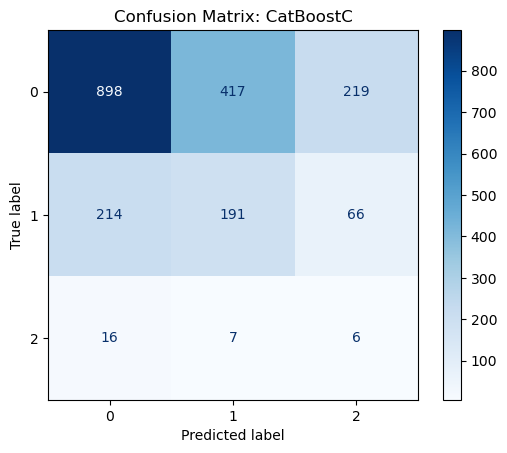

Model saved at: ml_model\ml_CatBoostC_FineTuneWord2Vec.joblib

Evaluating XGBoost...
Model Evaluation: XGBoost
F1 Score: 0.70930 | Accuracy: 0.72124 | Precision: 0.70095 | Recall: 0.72124 | Training Accuracy: 0.90108 | Validation Accuracy: 0.72124


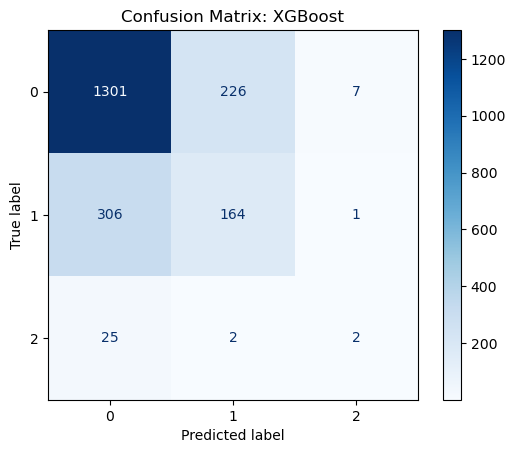

Model saved at: ml_model\ml_XGBoost_FineTuneWord2Vec.joblib

Evaluating MLPC-sgd...
Model Evaluation: MLPC-sgd
F1 Score: 0.37927 | Accuracy: 0.30187 | Precision: 0.65021 | Recall: 0.30187 | Training Accuracy: 0.41959 | Validation Accuracy: 0.30187


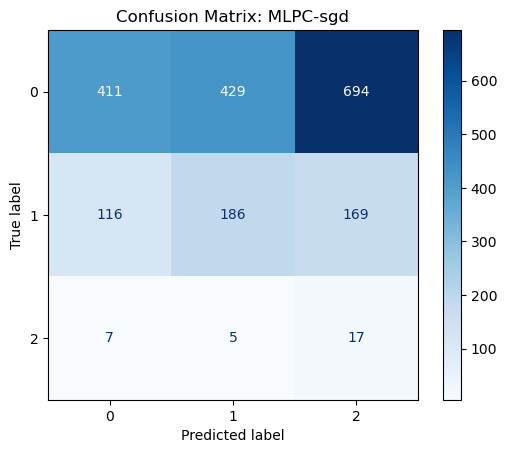

Model saved at: ml_model\ml_MLPC-sgd_FineTuneWord2Vec.joblib

Evaluating ExtraTreesC...
Model Evaluation: ExtraTreesC
F1 Score: 0.70275 | Accuracy: 0.75221 | Precision: 0.69877 | Recall: 0.75221 | Training Accuracy: 0.93059 | Validation Accuracy: 0.75221


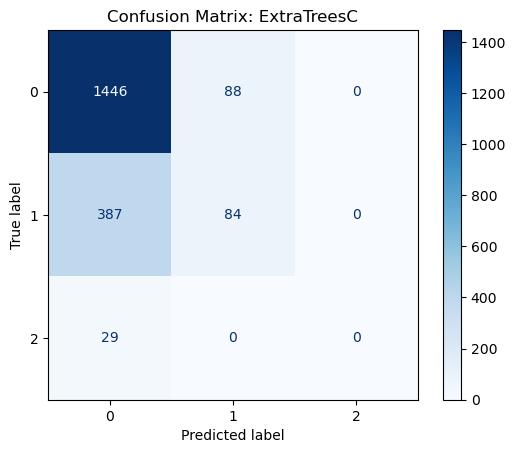

Model saved at: ml_model\ml_ExtraTreesC_FineTuneWord2Vec.joblib


In [41]:
df_W2v_ml = evaluate_multiple_models(
    X_train_Ft,X_test_Ft,y_train_Ft,y_test_Ft,
    modelsAndNames,
    vectorization_method="FineTuneWord2Vec"
)

In [42]:
results_df = pd.concat([results_df, df_W2v_ml], ignore_index=True)


FineTuneWord2Vec:
Epoch [1/50], Train Loss: 1.0773, Train Accuracy: 0.4746, Validation Loss: 1.3199, Validation Accuracy: 0.2316
Epoch [2/50], Train Loss: 1.1861, Train Accuracy: 0.3652, Validation Loss: 1.3199, Validation Accuracy: 0.2316
Epoch [3/50], Train Loss: 1.1874, Train Accuracy: 0.3638, Validation Loss: 1.3199, Validation Accuracy: 0.2316
Epoch [4/50], Train Loss: 1.1852, Train Accuracy: 0.3663, Validation Loss: 1.3199, Validation Accuracy: 0.2316
Epoch [5/50], Train Loss: 1.1756, Train Accuracy: 0.3758, Validation Loss: 1.3199, Validation Accuracy: 0.2316
Epoch [6/50], Train Loss: 1.1624, Train Accuracy: 0.3889, Validation Loss: 1.3199, Validation Accuracy: 0.2316
Epoch [7/50], Train Loss: 1.1318, Train Accuracy: 0.4195, Validation Loss: 1.3198, Validation Accuracy: 0.2316
Epoch [8/50], Train Loss: 1.1349, Train Accuracy: 0.4164, Validation Loss: 1.3171, Validation Accuracy: 0.2345
Epoch [9/50], Train Loss: 1.0214, Train Accuracy: 0.5300, Validation Loss: 1.3161, Validation

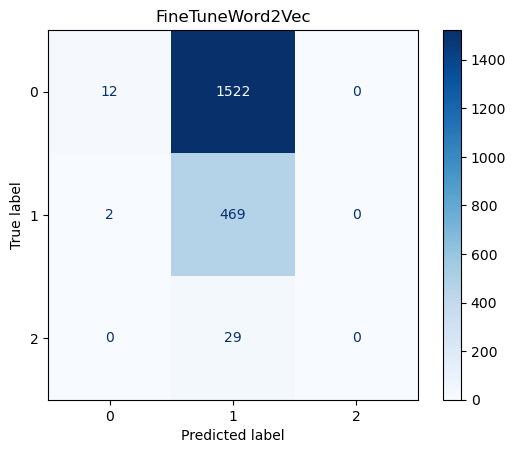

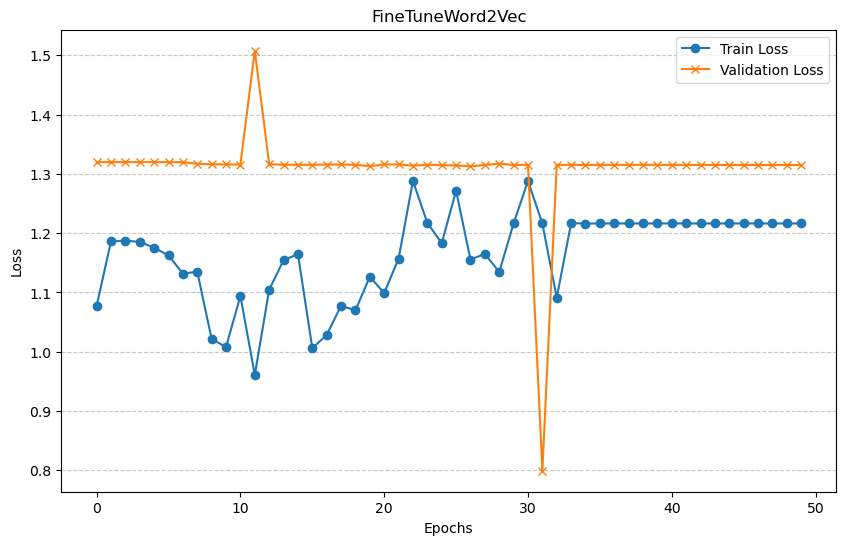

Model saved to models/FineTuneWord2Vec_ANN.pth
Results saved to models/FineTuneWord2Vec_results.csv


In [43]:
df_FTW = model_training(
    "FineTuneWord2Vec",
    X_train_Ft,X_test_Ft,
    y_train_Ft,y_test_Ft,
    len_labels
)

In [44]:
results_df = pd.concat([results_df, df_FTW], ignore_index=True)

In [45]:
results_df

,Model,Vectorization Method,Accuracy,Precision,Recall,F1 Score
0,CatBoostC,TurkishWord2Vec,0.629794,0.716249,0.629794,0.664940
1,XGBoost,TurkishWord2Vec,0.766962,0.749744,0.766962,0.757297
2,MLPC-sgd,TurkishWord2Vec,0.725664,0.767823,0.725664,0.741140
3,ExtraTreesC,TurkishWord2Vec,0.770403,0.730594,0.770403,0.735169
4,ANN,TurkishWord2Vec,0.161259,0.771834,0.161259,0.249338
5,CatBoostC,FineTuneWord2Vec,0.538348,0.672612,0.538348,0.590817
6,XGBoost,FineTuneWord2Vec,0.721239,0.700948,0.721239,0.709300
7,MLPC-sgd,FineTuneWord2Vec,0.301868,0.650208,0.301868,0.379265
8,ExtraTreesC,FineTuneWord2Vec,0.752212,0.698773,0.752212,0.702753
9,ANN,FineTuneWord2Vec,0.236480,0.700203,0.236480,0.098889


# GRAM in CountVectorizer and TfidfVectorizer ------------------------------

In [47]:
#Word unigram and bigram ,Char bigram and trigram

# Word  unigram
word_unigram_count = CountVectorizer(ngram_range=(1, 1) , analyzer='word',max_features=9000)  
word_unigram_tfidf = TfidfVectorizer(ngram_range=(1, 1) ,analyzer='word',max_features=9000)  # Word unigram TF-IDF

# Word bigram
word_bigram_count = CountVectorizer(ngram_range=(2, 2), analyzer='word',max_features=9000)  
word_bigram_tfidf = TfidfVectorizer(ngram_range=(2, 2), analyzer='word',max_features=9000)  # Word bigram TF-IDF

# Char  bigram 
char_bigram_count = CountVectorizer(ngram_range=(2, 2), analyzer='char',max_features=9000)  
char_bigram_tfidf = TfidfVectorizer(ngram_range=(2, 2), analyzer='char',max_features=9000)  # Char bigram TF-IDF

# Char trigram 
char_trigram_count = CountVectorizer(ngram_range=(3, 3), analyzer='char',max_features=9000)  
char_trigram_tfidf = TfidfVectorizer(ngram_range=(3, 3), analyzer='char',max_features=9000)  #Char trigram TF-IDF


# Word Unigram-------------------------------------------

In [49]:
feature_union = FeatureUnion([
    ("word_unigram_count", word_unigram_count),
    ("word_unigram_tfidf", word_unigram_tfidf)
])

In [50]:
%%time
X_train_vec,X_test_vec,y_train_vec,y_test_vec = makeVector(feature_union,X_train,X_test,y_train,y_test)

y_train shape: (8135,)
First 10 feature names: ['word_unigram_count__00' 'word_unigram_count__000'
 'word_unigram_count__01' 'word_unigram_count__02'
 'word_unigram_count__03' 'word_unigram_count__04'
 'word_unigram_count__05' 'word_unigram_count__06'
 'word_unigram_count__07' 'word_unigram_count__08']
X_train_features shape: (8135, 18000)
X_test_features shape: (2034, 18000)
Before sampling Counter({0: 6133, 1: 1865, 2: 137})
After sampling Counter({0: 6133, 1: 6133, 2: 6133})
X_train shape: (18399, 18000),y_train shape: (18399,),
CPU times: total: 10.9 s
Wall time: 3.49 s


In [51]:
print(X_test_vec.dtype)

print(X_train_vec.dtype)

print(y_train_vec.dtype)

print(y_test_vec.dtype)

print("NaN in X_train:", np.isnan(X_train_vec).sum())
print("Inf in X_train:", np.isinf(X_train_vec).sum())
print("Feature variances:", np.var(X_train_vec, axis=0))
print(X_train_vec)

float64
float64
int64
int64
NaN in X_train: 0
Inf in X_train: 0
Feature variances: [1.24159589e-03 3.76639776e-03 3.65886852e-04 ... 1.97946267e-05
 9.11982437e-06 9.11982437e-06]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [52]:
non_zero_count = np.count_nonzero(X_train_vec)

print(f"There are {non_zero_count} non-zero values in the dataset.")

There are 607576 non-zero values in the dataset.



Evaluating CatBoostC...
Model Evaluation: CatBoostC
F1 Score: 0.71618 | Accuracy: 0.70452 | Precision: 0.73122 | Recall: 0.70452 | Training Accuracy: 0.76972 | Validation Accuracy: 0.70452


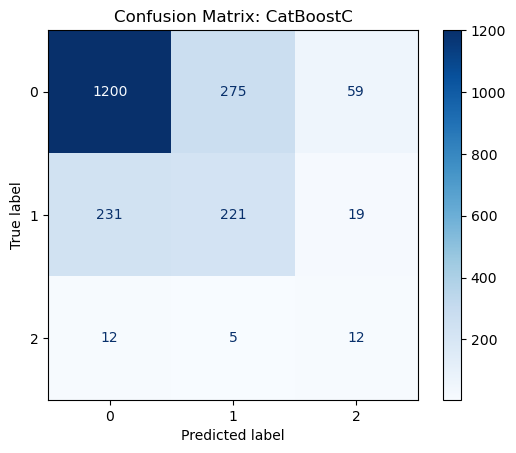

Model saved at: ml_model\ml_CatBoostC_WordUnigram.joblib

Evaluating XGBoost...
Model Evaluation: XGBoost
F1 Score: 0.79713 | Accuracy: 0.81613 | Precision: 0.79974 | Recall: 0.81613 | Training Accuracy: 0.86434 | Validation Accuracy: 0.81613


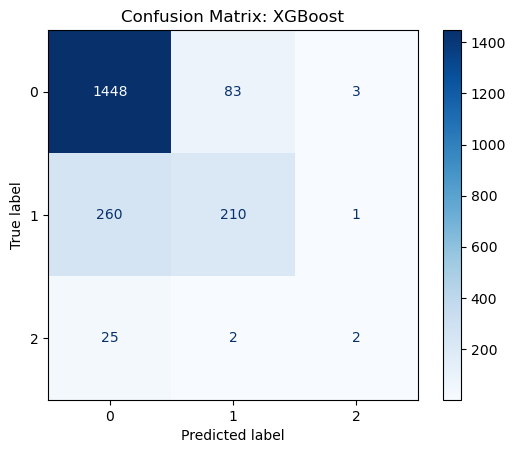

Model saved at: ml_model\ml_XGBoost_WordUnigram.joblib

Evaluating MLPC-sgd...
Model Evaluation: MLPC-sgd
F1 Score: 0.80779 | Accuracy: 0.80728 | Precision: 0.80863 | Recall: 0.80728 | Training Accuracy: 0.87228 | Validation Accuracy: 0.80728


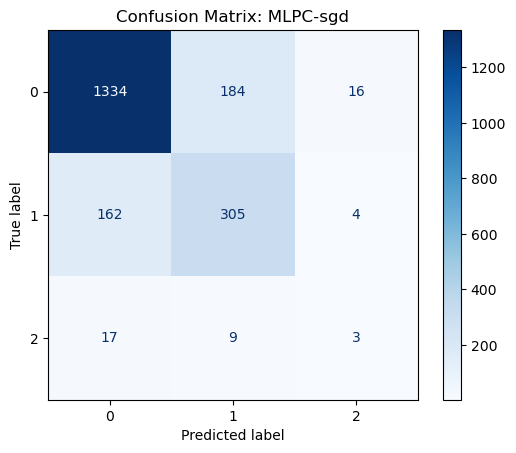

Model saved at: ml_model\ml_MLPC-sgd_WordUnigram.joblib

Evaluating ExtraTreesC...
Model Evaluation: ExtraTreesC
F1 Score: 0.81147 | Accuracy: 0.83530 | Precision: 0.82841 | Recall: 0.83530 | Training Accuracy: 0.95897 | Validation Accuracy: 0.83530


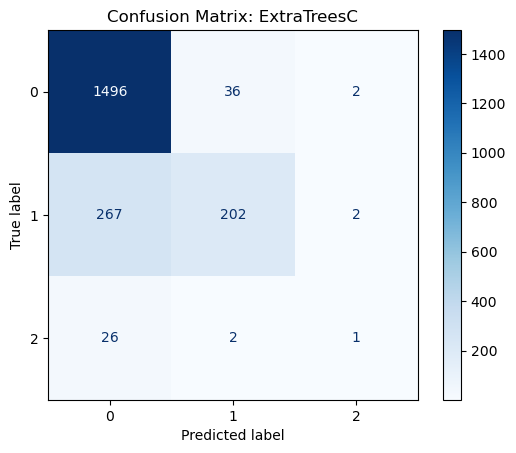

Model saved at: ml_model\ml_ExtraTreesC_WordUnigram.joblib
CPU times: total: 44min 42s
Wall time: 20min 23s


In [53]:
%%time
df_WU_ml = evaluate_multiple_models(
    X_train_vec,X_test_vec,y_train_vec,y_test_vec,
    modelsAndNames,
    vectorization_method="WordUnigram"
)

In [54]:
results_df = pd.concat([results_df, df_WU_ml], ignore_index=True)


WordUnigram:
Epoch [1/50], Train Loss: 0.6583, Train Accuracy: 0.8921, Validation Loss: 1.5371, Validation Accuracy: 0.0143
Epoch [2/50], Train Loss: 0.6192, Train Accuracy: 0.9316, Validation Loss: 1.4842, Validation Accuracy: 0.0654
Epoch [3/50], Train Loss: 0.6274, Train Accuracy: 0.9234, Validation Loss: 1.4522, Validation Accuracy: 0.0973
Epoch [4/50], Train Loss: 0.5840, Train Accuracy: 0.9670, Validation Loss: 1.2072, Validation Accuracy: 0.3358
Epoch [5/50], Train Loss: 0.5739, Train Accuracy: 0.9776, Validation Loss: 1.3247, Validation Accuracy: 0.2109
Epoch [6/50], Train Loss: 0.5695, Train Accuracy: 0.9820, Validation Loss: 1.3321, Validation Accuracy: 0.2124
Epoch [7/50], Train Loss: 0.5678, Train Accuracy: 0.9835, Validation Loss: 1.2770, Validation Accuracy: 0.2380
Epoch [8/50], Train Loss: 0.5664, Train Accuracy: 0.9851, Validation Loss: 1.1393, Validation Accuracy: 0.4036
Epoch [9/50], Train Loss: 0.5638, Train Accuracy: 0.9876, Validation Loss: 0.9697, Validation Accu

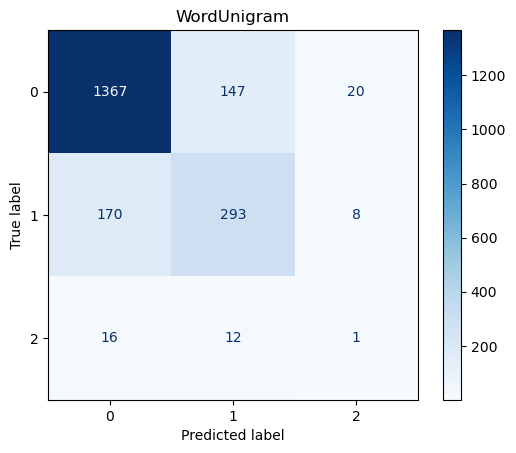

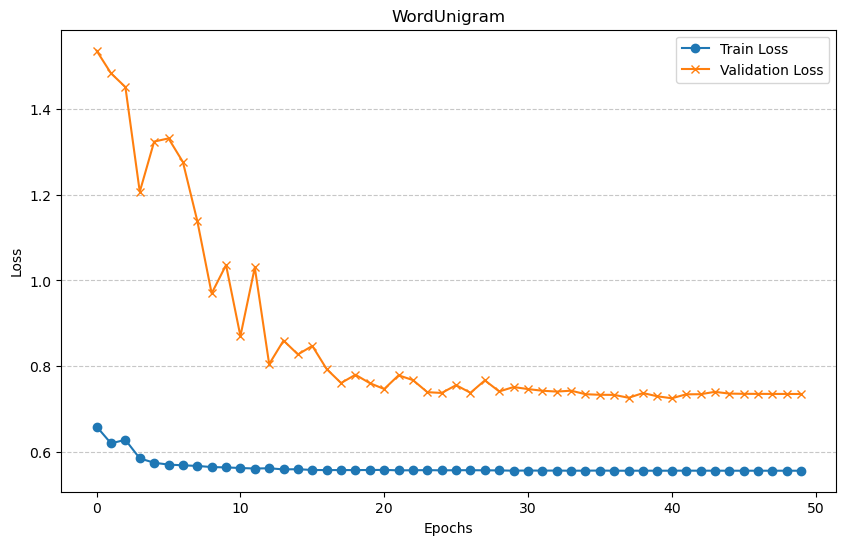

Model saved to models/WordUnigram_ANN.pth
Results saved to models/WordUnigram_results.csv
Model training completed successfully.
Model metric saved
CPU times: total: 26.6 s
Wall time: 17min 50s


In [55]:
%%time
try:
    df_WU = model_training("WordUnigram", X_train_vec, X_test_vec, y_train_vec, y_test_vec,len_labels)

except Exception as e:
    print("An error occurred during model training:")
    print(e)
    clear_memory()

else:
    print("Model training completed successfully.")
    results_df = pd.concat([results_df, df_WU], ignore_index=True)
    print("Model metric saved")

In [56]:
results_df

,Model,Vectorization Method,Accuracy,Precision,Recall,F1 Score
0,CatBoostC,TurkishWord2Vec,0.629794,0.716249,0.629794,0.664940
1,XGBoost,TurkishWord2Vec,0.766962,0.749744,0.766962,0.757297
2,MLPC-sgd,TurkishWord2Vec,0.725664,0.767823,0.725664,0.741140
3,ExtraTreesC,TurkishWord2Vec,0.770403,0.730594,0.770403,0.735169
4,ANN,TurkishWord2Vec,0.161259,0.771834,0.161259,0.249338
5,CatBoostC,FineTuneWord2Vec,0.538348,0.672612,0.538348,0.590817
6,XGBoost,FineTuneWord2Vec,0.721239,0.700948,0.721239,0.709300
7,MLPC-sgd,FineTuneWord2Vec,0.301868,0.650208,0.301868,0.379265
8,ExtraTreesC,FineTuneWord2Vec,0.752212,0.698773,0.752212,0.702753
9,ANN,FineTuneWord2Vec,0.236480,0.700203,0.236480,0.098889


In [57]:
clear_memory()

Cleared memory.
now memory used: 4405.54 MB


# Word Bigram-------------------------------------------

In [59]:
feature_union = FeatureUnion([
    ("word_bigram_count", word_bigram_count),
    ("word_bigram_tfidf", word_bigram_tfidf)
])

In [60]:
X_train_vec,X_test_vec,y_train_vec,y_test_vec = makeVector(feature_union,X_train,X_test,y_train,y_test)

y_train shape: (8135,)
First 10 feature names: ['word_bigram_count__00 15' 'word_bigram_count__000 000'
 'word_bigram_count__000 ermeni' 'word_bigram_count__05 eylül'
 'word_bigram_count__10 10' 'word_bigram_count__10 bin'
 'word_bigram_count__10 gün' 'word_bigram_count__10 milyon'
 'word_bigram_count__10 sen' 'word_bigram_count__10 yıl']
X_train_features shape: (8135, 18000)
X_test_features shape: (2034, 18000)
Before sampling Counter({0: 6133, 1: 1865, 2: 137})
After sampling Counter({0: 6133, 1: 6133, 2: 6133})
X_train shape: (18399, 18000),y_train shape: (18399,),



Evaluating CatBoostC...
Model Evaluation: CatBoostC
F1 Score: 0.70701 | Accuracy: 0.72960 | Precision: 0.71067 | Recall: 0.72960 | Training Accuracy: 0.58297 | Validation Accuracy: 0.72960


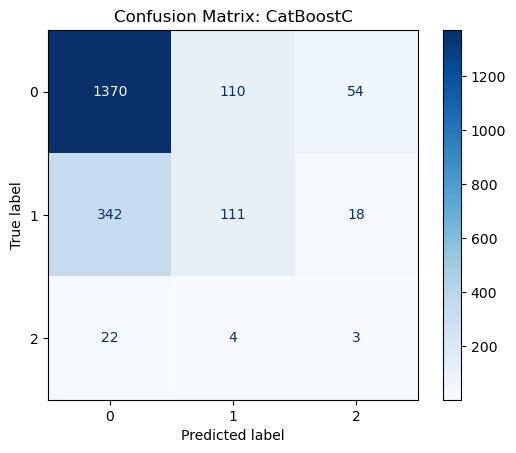

Model saved at: ml_model\ml_CatBoostC_WordBigram.joblib

Evaluating XGBoost...
Model Evaluation: XGBoost
F1 Score: 0.75554 | Accuracy: 0.78368 | Precision: 0.75822 | Recall: 0.78368 | Training Accuracy: 0.73846 | Validation Accuracy: 0.78368


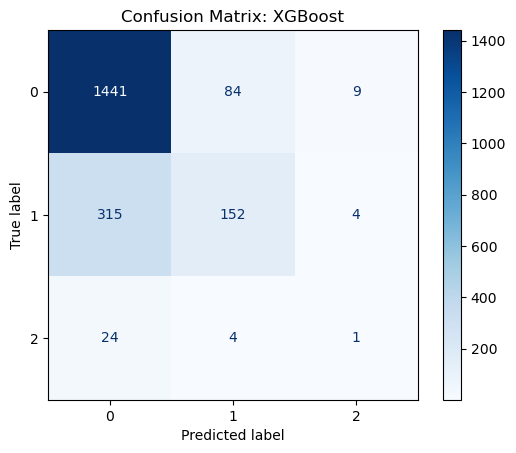

Model saved at: ml_model\ml_XGBoost_WordBigram.joblib

Evaluating MLPC-sgd...
Model Evaluation: MLPC-sgd
F1 Score: 0.68198 | Accuracy: 0.64897 | Precision: 0.73319 | Recall: 0.64897 | Training Accuracy: 0.64215 | Validation Accuracy: 0.64897


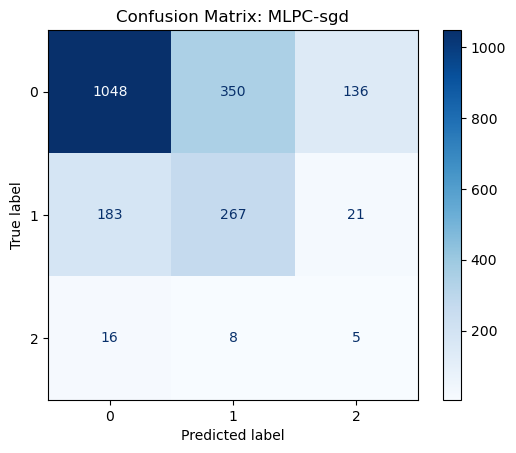

Model saved at: ml_model\ml_MLPC-sgd_WordBigram.joblib

Evaluating ExtraTreesC...
Model Evaluation: ExtraTreesC
F1 Score: 0.76044 | Accuracy: 0.76450 | Precision: 0.75917 | Recall: 0.76450 | Training Accuracy: 0.86189 | Validation Accuracy: 0.76450


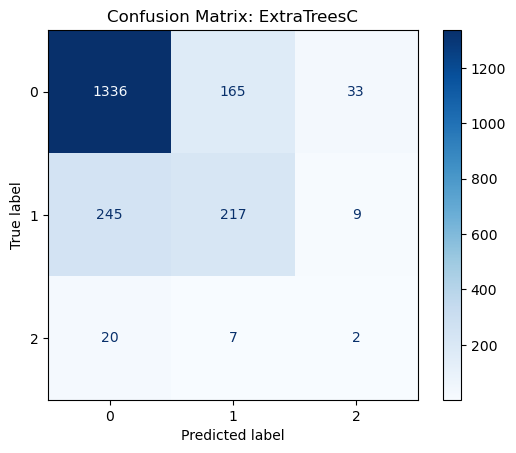

Model saved at: ml_model\ml_ExtraTreesC_WordBigram.joblib


In [61]:
df_WB_ml = evaluate_multiple_models(
    X_train_vec,X_test_vec,
    y_train_vec,y_test_vec,
    modelsAndNames,
    vectorization_method="WordBigram"
)

In [62]:
results_df = pd.concat([results_df, df_WB_ml], ignore_index=True)


WordBigram:
Epoch [1/50], Train Loss: 0.6725, Train Accuracy: 0.8776, Validation Loss: 1.5359, Validation Accuracy: 0.0143
Epoch [2/50], Train Loss: 0.6214, Train Accuracy: 0.9296, Validation Loss: 1.5370, Validation Accuracy: 0.0143
Epoch [3/50], Train Loss: 0.6055, Train Accuracy: 0.9453, Validation Loss: 1.5371, Validation Accuracy: 0.0143
Epoch [4/50], Train Loss: 0.5913, Train Accuracy: 0.9602, Validation Loss: 1.4198, Validation Accuracy: 0.1224
Epoch [5/50], Train Loss: 0.5814, Train Accuracy: 0.9701, Validation Loss: 1.4018, Validation Accuracy: 0.1416
Epoch [6/50], Train Loss: 0.5782, Train Accuracy: 0.9730, Validation Loss: 1.3290, Validation Accuracy: 0.2188
Epoch [7/50], Train Loss: 0.5770, Train Accuracy: 0.9743, Validation Loss: 1.3955, Validation Accuracy: 0.1495
Epoch [8/50], Train Loss: 0.5770, Train Accuracy: 0.9745, Validation Loss: 1.4224, Validation Accuracy: 0.1195
Epoch [9/50], Train Loss: 0.5760, Train Accuracy: 0.9753, Validation Loss: 1.2091, Validation Accur

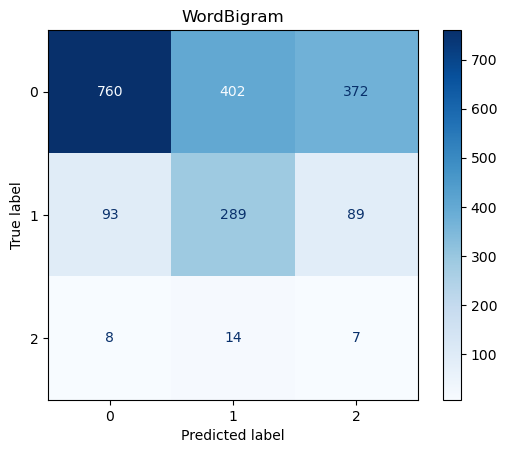

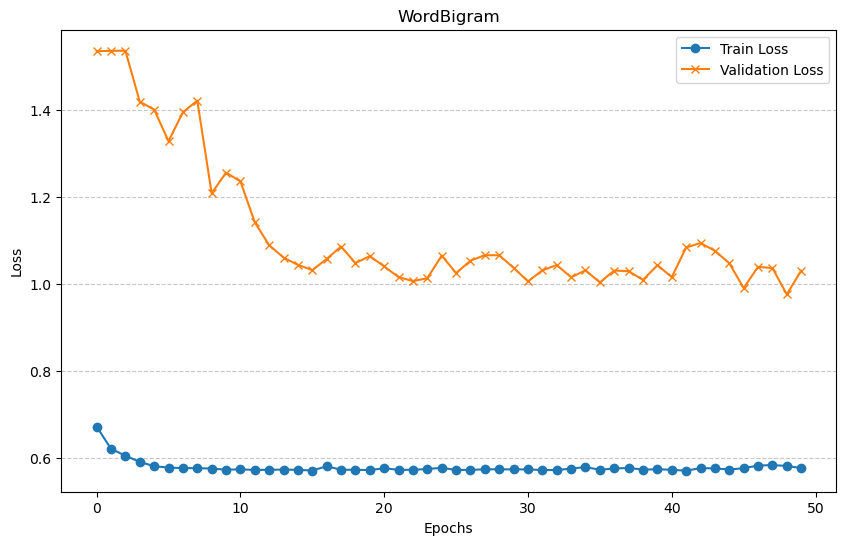

Model saved to models/WordBigram_ANN.pth
Results saved to models/WordBigram_results.csv
Model training completed successfully.
Model metric saved


In [63]:
try:
    df_WB = model_training("WordBigram", X_train_vec, X_test_vec, y_train_vec, y_test_vec,len_labels)

except Exception as e:
    print("An error occurred during model training:")
    print(e)
    clear_memory()

else:
    print("Model training completed successfully.")
    results_df = pd.concat([results_df, df_WB], ignore_index=True)
    print("Model metric saved")

In [64]:
clear_memory()

Cleared memory.
now memory used: 3855.31 MB


# Char Bigram-------------------------------------------

In [66]:
feature_union = FeatureUnion([
    ("char_bigram_count", char_bigram_count),
    ("char_bigram_tfidf", char_bigram_tfidf)
])

In [67]:
X_train_vec,X_test_vec,y_train_vec,y_test_vec = makeVector(feature_union,X_train,X_test,y_train,y_test)

y_train shape: (8135,)
First 10 feature names: ['char_bigram_count__ 0' 'char_bigram_count__ 1' 'char_bigram_count__ 2'
 'char_bigram_count__ 3' 'char_bigram_count__ 4' 'char_bigram_count__ 5'
 'char_bigram_count__ 6' 'char_bigram_count__ 7' 'char_bigram_count__ 8'
 'char_bigram_count__ 9']
X_train_features shape: (8135, 3078)
X_test_features shape: (2034, 3078)
Before sampling Counter({0: 6133, 1: 1865, 2: 137})
After sampling Counter({0: 6133, 1: 6133, 2: 6133})
X_train shape: (18399, 3078),y_train shape: (18399,),



Evaluating CatBoostC...
Model Evaluation: CatBoostC
F1 Score: 0.72427 | Accuracy: 0.76155 | Precision: 0.72881 | Recall: 0.76155 | Training Accuracy: 0.80450 | Validation Accuracy: 0.76155


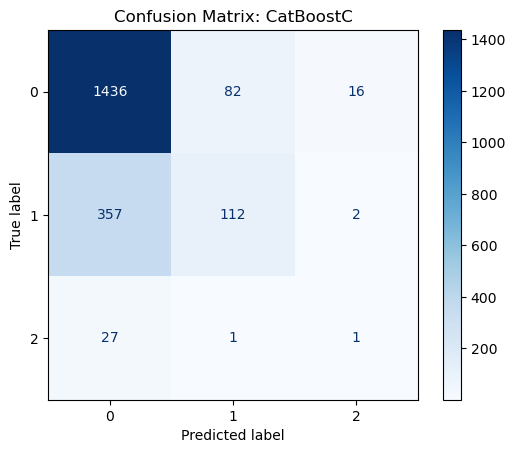

Model saved at: ml_model\ml_CatBoostC_CharBigram.joblib

Evaluating XGBoost...
Model Evaluation: XGBoost
F1 Score: 0.80010 | Accuracy: 0.82645 | Precision: 0.81219 | Recall: 0.82645 | Training Accuracy: 0.87363 | Validation Accuracy: 0.82645


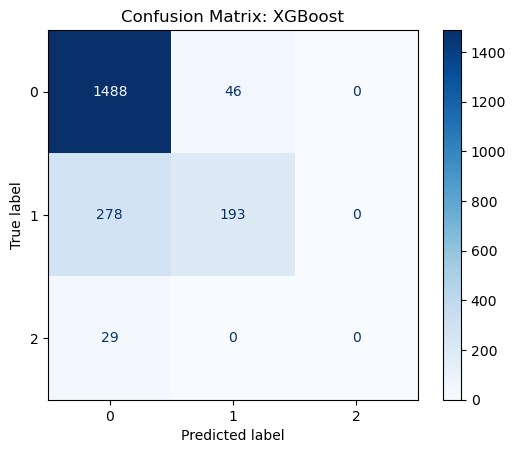

Model saved at: ml_model\ml_XGBoost_CharBigram.joblib

Evaluating MLPC-sgd...
Model Evaluation: MLPC-sgd
F1 Score: 0.75012 | Accuracy: 0.73107 | Precision: 0.79073 | Recall: 0.73107 | Training Accuracy: 0.81689 | Validation Accuracy: 0.73107


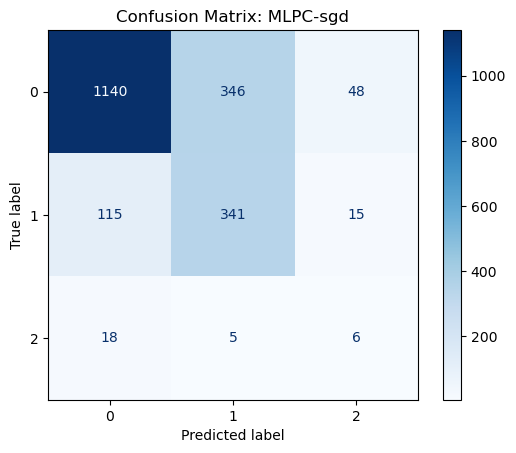

Model saved at: ml_model\ml_MLPC-sgd_CharBigram.joblib

Evaluating ExtraTreesC...
Model Evaluation: ExtraTreesC
F1 Score: 0.72724 | Accuracy: 0.79007 | Precision: 0.80668 | Recall: 0.79007 | Training Accuracy: 0.96022 | Validation Accuracy: 0.79007


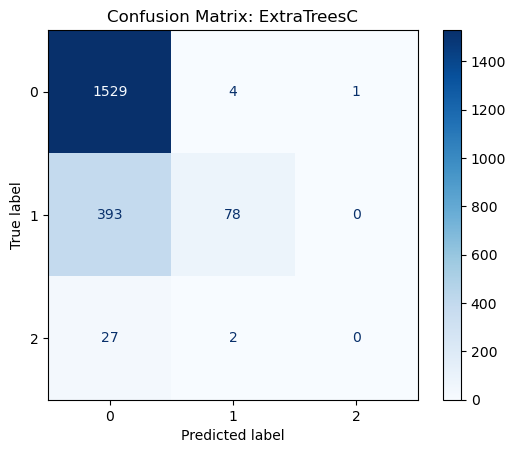

Model saved at: ml_model\ml_ExtraTreesC_CharBigram.joblib


In [68]:
df_CB_ml = evaluate_multiple_models(
    X_train_vec,X_test_vec,
    y_train_vec,y_test_vec,
    modelsAndNames,
    vectorization_method="CharBigram"
)

In [69]:
results_df = pd.concat([results_df, df_CB_ml], ignore_index=True)


CharBigram:
Epoch [1/50], Train Loss: 0.9904, Train Accuracy: 0.5613, Validation Loss: 1.3199, Validation Accuracy: 0.2316
Epoch [2/50], Train Loss: 1.2181, Train Accuracy: 0.3333, Validation Loss: 1.3199, Validation Accuracy: 0.2316
Epoch [3/50], Train Loss: 1.0003, Train Accuracy: 0.5511, Validation Loss: 1.3199, Validation Accuracy: 0.2316
Epoch [4/50], Train Loss: 1.0062, Train Accuracy: 0.5452, Validation Loss: 1.3199, Validation Accuracy: 0.2316
Epoch [5/50], Train Loss: 0.7634, Train Accuracy: 0.7878, Validation Loss: 1.5362, Validation Accuracy: 0.0152
Epoch [6/50], Train Loss: 0.8843, Train Accuracy: 0.6667, Validation Loss: 1.5317, Validation Accuracy: 0.0197
Epoch [7/50], Train Loss: 0.7651, Train Accuracy: 0.7850, Validation Loss: 1.5199, Validation Accuracy: 0.0305
Epoch [8/50], Train Loss: 0.6746, Train Accuracy: 0.8765, Validation Loss: 1.5237, Validation Accuracy: 0.0275
Epoch [9/50], Train Loss: 0.7067, Train Accuracy: 0.8445, Validation Loss: 1.5314, Validation Accur

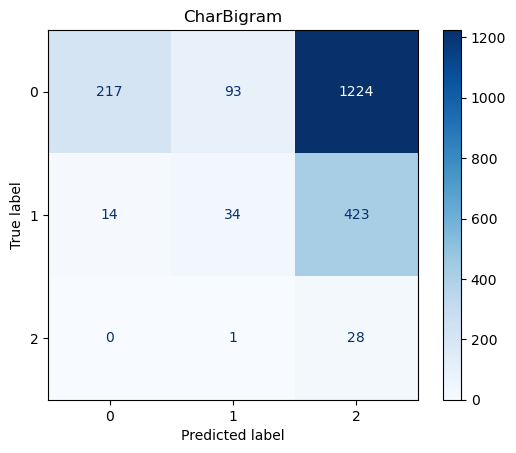

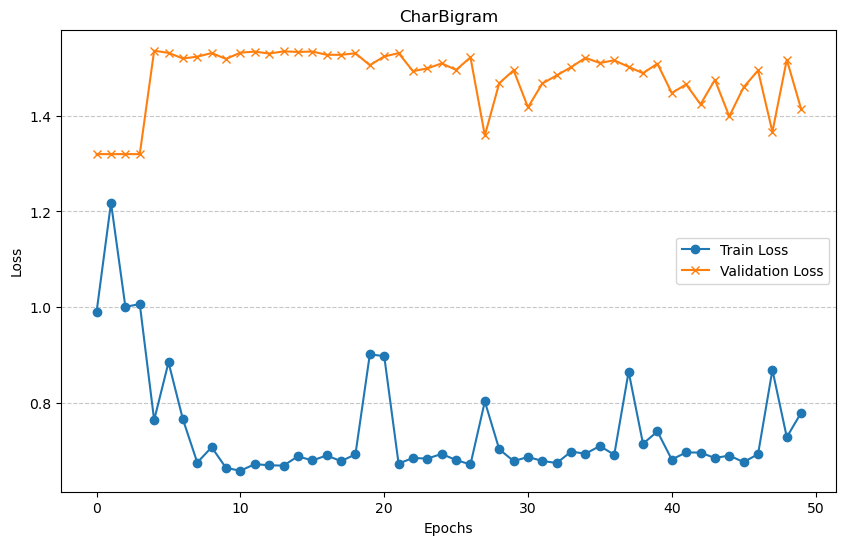

Model saved to models/CharBigram_ANN.pth
Results saved to models/CharBigram_results.csv
Model training completed successfully.
Model metric saved


In [70]:
try:
    df_CB = model_training( "CharBigram", X_train_vec, X_test_vec, y_train_vec, y_test_vec,len_labels)

except Exception as e:
    print("An error occurred during model training:")
    print(e)
    clear_memory()

else:
    print("Model training completed successfully.")
    results_df = pd.concat([results_df, df_CB], ignore_index=True)
    print("Model metric saved")

In [71]:
clear_memory()

Cleared memory.
now memory used: 1447.25 MB


# Char Trigram-------------------------------------------

In [73]:
feature_union = FeatureUnion([
    ("char_trigram_count", char_trigram_count),
    ("char_trigram_tfidf", char_trigram_tfidf)
])

In [74]:
X_train_vec,X_test_vec,y_train_vec,y_test_vec = makeVector(feature_union,X_train,X_test,y_train,y_test)

y_train shape: (8135,)
First 10 feature names: ['char_trigram_count__ 00' 'char_trigram_count__ 01'
 'char_trigram_count__ 02' 'char_trigram_count__ 03'
 'char_trigram_count__ 04' 'char_trigram_count__ 05'
 'char_trigram_count__ 06' 'char_trigram_count__ 07'
 'char_trigram_count__ 08' 'char_trigram_count__ 09']
X_train_features shape: (8135, 18000)
X_test_features shape: (2034, 18000)
Before sampling Counter({0: 6133, 1: 1865, 2: 137})
After sampling Counter({0: 6133, 1: 6133, 2: 6133})
X_train shape: (18399, 18000),y_train shape: (18399,),



Evaluating CatBoostC...
Model Evaluation: CatBoostC
F1 Score: 0.72919 | Accuracy: 0.74140 | Precision: 0.72497 | Recall: 0.74140 | Training Accuracy: 0.81613 | Validation Accuracy: 0.74140


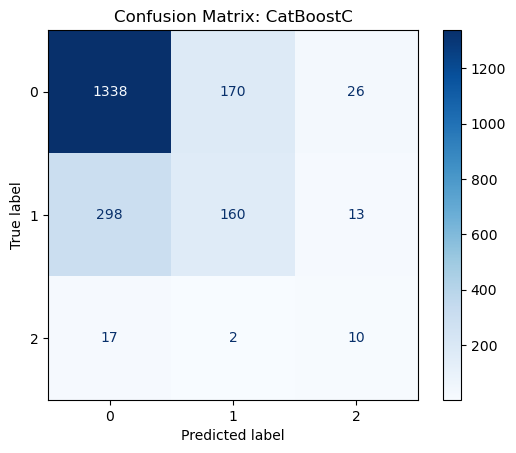

Model saved at: ml_model\ml_CatBoostC_CharTrigram.joblib

Evaluating XGBoost...
Model Evaluation: XGBoost
F1 Score: 0.81677 | Accuracy: 0.83874 | Precision: 0.83231 | Recall: 0.83874 | Training Accuracy: 0.87690 | Validation Accuracy: 0.83874


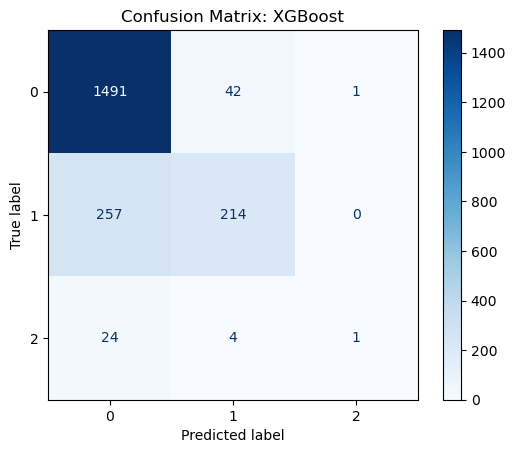

Model saved at: ml_model\ml_XGBoost_CharTrigram.joblib

Evaluating MLPC-sgd...
Model Evaluation: MLPC-sgd
F1 Score: 0.81990 | Accuracy: 0.81908 | Precision: 0.82139 | Recall: 0.81908 | Training Accuracy: 0.92038 | Validation Accuracy: 0.81908


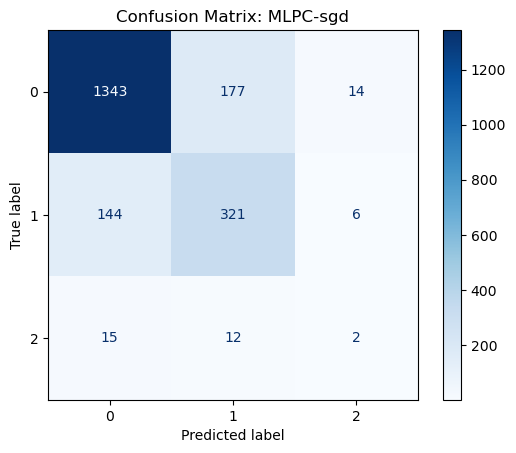

Model saved at: ml_model\ml_MLPC-sgd_CharTrigram.joblib

Evaluating ExtraTreesC...
Model Evaluation: ExtraTreesC
F1 Score: 0.75691 | Accuracy: 0.80629 | Precision: 0.83239 | Recall: 0.80629 | Training Accuracy: 0.95185 | Validation Accuracy: 0.80629


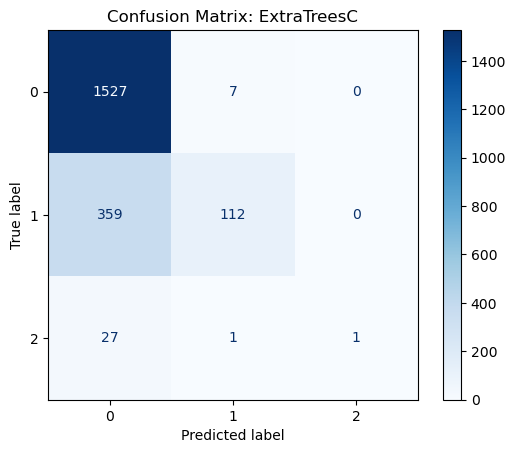

Model saved at: ml_model\ml_ExtraTreesC_CharTrigram.joblib


In [75]:
df_CT_ml = evaluate_multiple_models(
    X_train_vec,X_test_vec,
    y_train_vec,y_test_vec,
    modelsAndNames,
    vectorization_method="CharTrigram"
)

In [76]:
results_df = pd.concat([results_df, df_CT_ml], ignore_index=True)


CharTrigram:
Epoch [1/50], Train Loss: 0.7166, Train Accuracy: 0.8345, Validation Loss: 1.5372, Validation Accuracy: 0.0143
Epoch [2/50], Train Loss: 0.6519, Train Accuracy: 0.8989, Validation Loss: 1.5290, Validation Accuracy: 0.0162
Epoch [3/50], Train Loss: 0.6276, Train Accuracy: 0.9231, Validation Loss: 1.4407, Validation Accuracy: 0.0998
Epoch [4/50], Train Loss: 0.6203, Train Accuracy: 0.9307, Validation Loss: 1.4317, Validation Accuracy: 0.1091
Epoch [5/50], Train Loss: 0.6203, Train Accuracy: 0.9308, Validation Loss: 1.4285, Validation Accuracy: 0.1146
Epoch [6/50], Train Loss: 0.6080, Train Accuracy: 0.9432, Validation Loss: 1.4864, Validation Accuracy: 0.0619
Epoch [7/50], Train Loss: 0.6102, Train Accuracy: 0.9406, Validation Loss: 1.4130, Validation Accuracy: 0.1313
Epoch [8/50], Train Loss: 0.6036, Train Accuracy: 0.9477, Validation Loss: 1.3828, Validation Accuracy: 0.1632
Epoch [9/50], Train Loss: 0.6073, Train Accuracy: 0.9439, Validation Loss: 1.4339, Validation Accu

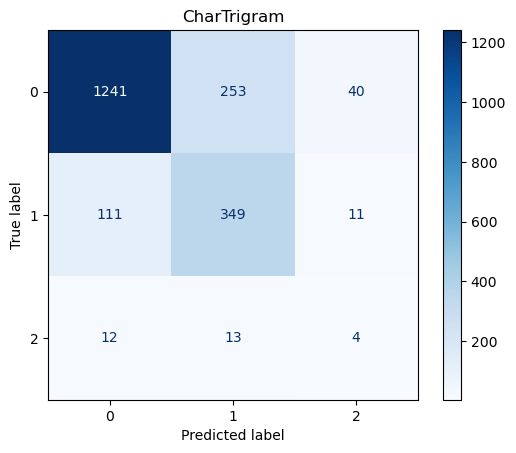

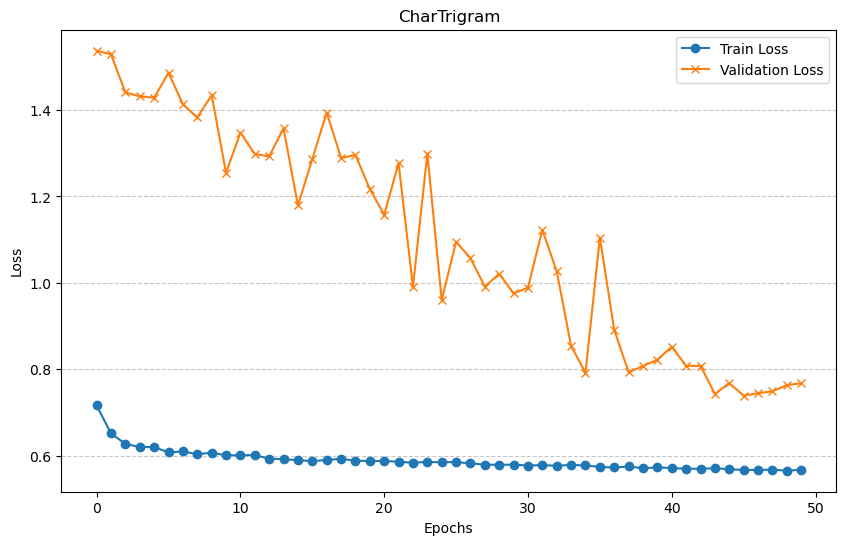

Model saved to models/CharTrigram_ANN.pth
Results saved to models/CharTrigram_results.csv
Model training completed successfully.
Model metric saved


In [77]:
try:
    df_CT = model_training( "CharTrigram", X_train_vec, X_test_vec, y_train_vec, y_test_vec,len_labels)

except Exception as e:
    print("An error occurred during model training:")
    print(e)
    clear_memory()

else:
    print("Model training completed successfully.")
    results_df = pd.concat([results_df, df_CT], ignore_index=True)
    print("Model metric saved")

In [78]:
clear_memory()

Cleared memory.
now memory used: 3827.59 MB


# Char Bigram + Char Trigram-------------------------------------------

In [80]:
feature_union = FeatureUnion([
    ("word_bigram_count", word_bigram_count),
    ("word_bigram_tfidf", word_bigram_tfidf),

    ("char_trigram_count", char_trigram_count),
    ("char_trigram_tfidf", char_trigram_tfidf)
])

In [81]:
X_train_vec,X_test_vec,y_train_vec,y_test_vec = makeVector(feature_union,X_train,X_test,y_train,y_test)

y_train shape: (8135,)
First 10 feature names: ['word_bigram_count__00 15' 'word_bigram_count__000 000'
 'word_bigram_count__000 ermeni' 'word_bigram_count__05 eylül'
 'word_bigram_count__10 10' 'word_bigram_count__10 bin'
 'word_bigram_count__10 gün' 'word_bigram_count__10 milyon'
 'word_bigram_count__10 sen' 'word_bigram_count__10 yıl']
X_train_features shape: (8135, 36000)
X_test_features shape: (2034, 36000)
Before sampling Counter({0: 6133, 1: 1865, 2: 137})
After sampling Counter({0: 6133, 1: 6133, 2: 6133})
X_train shape: (18399, 36000),y_train shape: (18399,),



Evaluating CatBoostC...
Model Evaluation: CatBoostC
F1 Score: 0.72648 | Accuracy: 0.74140 | Precision: 0.71916 | Recall: 0.74140 | Training Accuracy: 0.81521 | Validation Accuracy: 0.74140


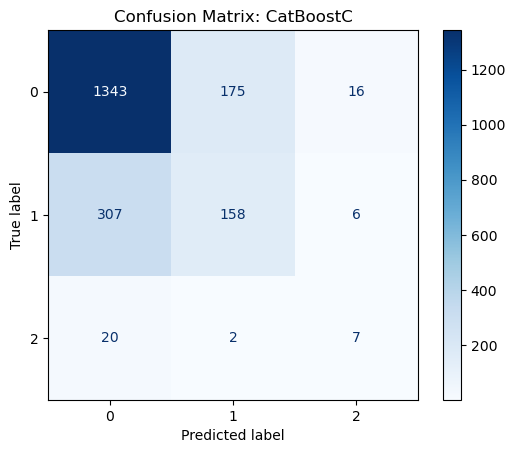

Model saved at: ml_model\ml_CatBoostC_ChBigram+ChTrigram.joblib

Evaluating XGBoost...
Model Evaluation: XGBoost
F1 Score: 0.81524 | Accuracy: 0.83825 | Precision: 0.82437 | Recall: 0.83825 | Training Accuracy: 0.87684 | Validation Accuracy: 0.83825


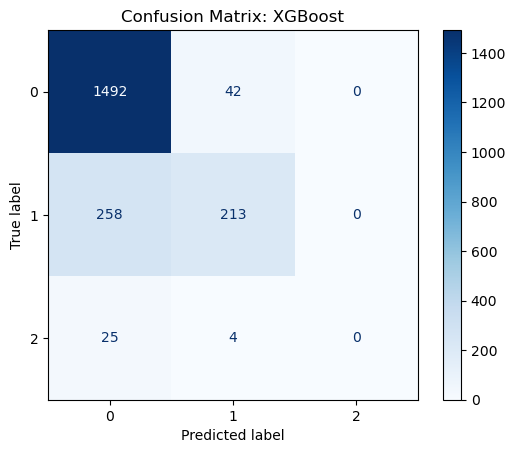

Model saved at: ml_model\ml_XGBoost_ChBigram+ChTrigram.joblib

Evaluating MLPC-sgd...
Model Evaluation: MLPC-sgd
F1 Score: 0.82823 | Accuracy: 0.82940 | Precision: 0.82718 | Recall: 0.82940 | Training Accuracy: 0.93206 | Validation Accuracy: 0.82940


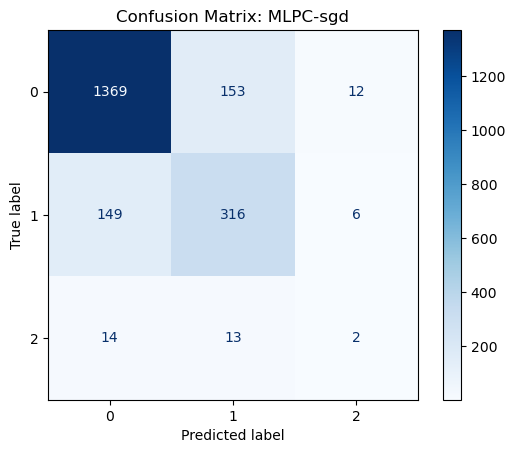

Model saved at: ml_model\ml_MLPC-sgd_ChBigram+ChTrigram.joblib

Evaluating ExtraTreesC...
Model Evaluation: ExtraTreesC
F1 Score: 0.75243 | Accuracy: 0.80383 | Precision: 0.81603 | Recall: 0.80383 | Training Accuracy: 0.95435 | Validation Accuracy: 0.80383


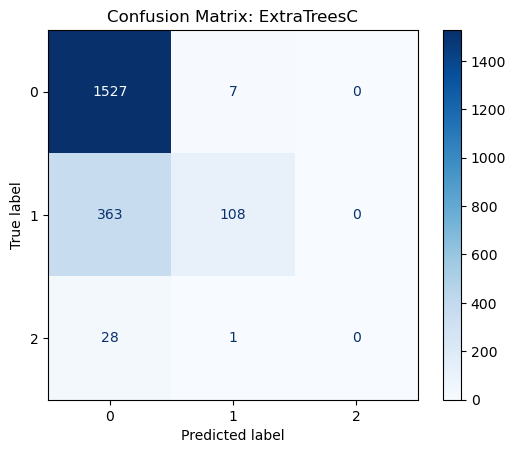

Model saved at: ml_model\ml_ExtraTreesC_ChBigram+ChTrigram.joblib


In [82]:
df_CBCT_ml = evaluate_multiple_models(
    X_train_vec,X_test_vec,
    y_train_vec,y_test_vec,
    modelsAndNames,
    vectorization_method="ChBigram+ChTrigram"
)

In [83]:
results_df = pd.concat([results_df, df_CBCT_ml], ignore_index=True)


ChBigram+ChTrigram:
Epoch [1/50], Train Loss: 0.6984, Train Accuracy: 0.8535, Validation Loss: 1.5309, Validation Accuracy: 0.0192
Epoch [2/50], Train Loss: 0.6441, Train Accuracy: 0.9065, Validation Loss: 1.5246, Validation Accuracy: 0.0256
Epoch [3/50], Train Loss: 0.6272, Train Accuracy: 0.9237, Validation Loss: 1.4889, Validation Accuracy: 0.0595
Epoch [4/50], Train Loss: 0.6161, Train Accuracy: 0.9347, Validation Loss: 1.4207, Validation Accuracy: 0.1268
Epoch [5/50], Train Loss: 0.6064, Train Accuracy: 0.9449, Validation Loss: 1.3921, Validation Accuracy: 0.1495
Epoch [6/50], Train Loss: 0.6005, Train Accuracy: 0.9508, Validation Loss: 1.3653, Validation Accuracy: 0.1804
Epoch [7/50], Train Loss: 0.5984, Train Accuracy: 0.9528, Validation Loss: 1.4047, Validation Accuracy: 0.1436
Epoch [8/50], Train Loss: 0.5985, Train Accuracy: 0.9527, Validation Loss: 1.2687, Validation Accuracy: 0.2797
Epoch [9/50], Train Loss: 0.5902, Train Accuracy: 0.9611, Validation Loss: 1.1985, Validati

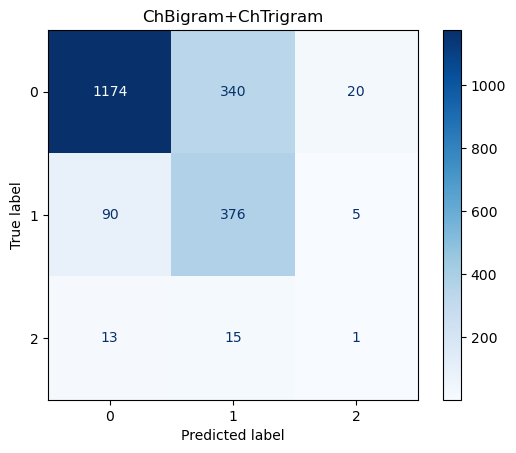

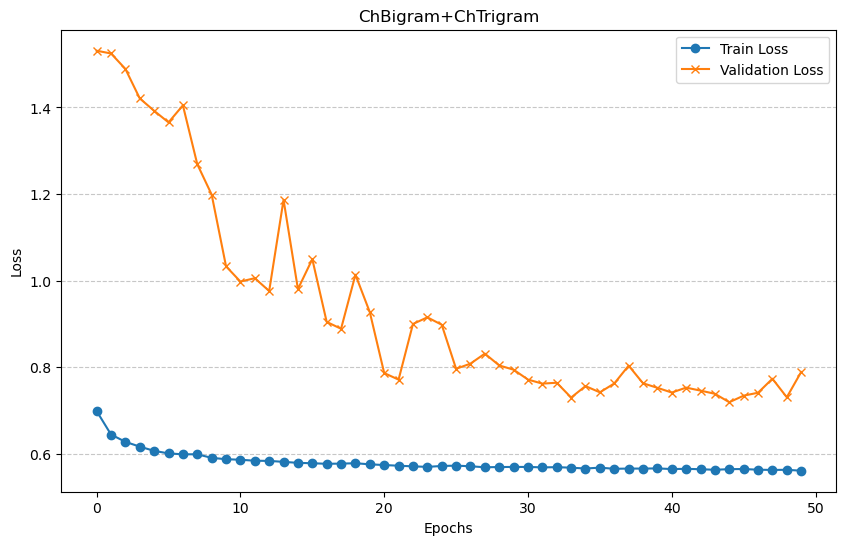

Model saved to models/ChBigram+ChTrigram_ANN.pth
Results saved to models/ChBigram+ChTrigram_results.csv
Model training completed successfully.
Model metric saved


In [84]:
try:
    df_CBCT = model_training( "ChBigram+ChTrigram",
                               X_train_vec, X_test_vec,
                               y_train_vec, y_test_vec,
                               len_labels)

except Exception as e:
    print("An error occurred during model training:")
    print(e)
    clear_memory()

else:
    print("Model training completed successfully.")
    results_df = pd.concat([results_df, df_CBCT], ignore_index=True)
    print("Model metric saved")

In [85]:
clear_memory()

Cleared memory.
now memory used: 6528.61 MB


# Char Unigram + Char Trigram-------------------------------------------

In [87]:
feature_union = FeatureUnion([
    ("word_unigram_count", word_unigram_count),
    ("word_unigram_tfidf", word_unigram_tfidf),

    ("char_trigram_count", char_trigram_count),
    ("char_trigram_tfidf", char_trigram_tfidf)

])

In [88]:
X_train_vec,X_test_vec,y_train_vec,y_test_vec = makeVector(feature_union,X_train,X_test,y_train,y_test)

y_train shape: (8135,)
First 10 feature names: ['word_unigram_count__00' 'word_unigram_count__000'
 'word_unigram_count__01' 'word_unigram_count__02'
 'word_unigram_count__03' 'word_unigram_count__04'
 'word_unigram_count__05' 'word_unigram_count__06'
 'word_unigram_count__07' 'word_unigram_count__08']
X_train_features shape: (8135, 36000)
X_test_features shape: (2034, 36000)
Before sampling Counter({0: 6133, 1: 1865, 2: 137})
After sampling Counter({0: 6133, 1: 6133, 2: 6133})
X_train shape: (18399, 36000),y_train shape: (18399,),



Evaluating CatBoostC...
Model Evaluation: CatBoostC
F1 Score: 0.72447 | Accuracy: 0.73992 | Precision: 0.71842 | Recall: 0.73992 | Training Accuracy: 0.81765 | Validation Accuracy: 0.73992


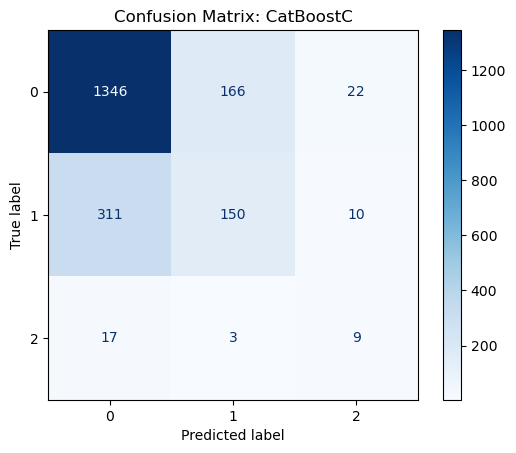

Model saved at: ml_model\ml_CatBoostC_ChUnigram+ChTrigram.joblib

Evaluating XGBoost...
Model Evaluation: XGBoost
F1 Score: 0.82559 | Accuracy: 0.84808 | Precision: 0.85406 | Recall: 0.84808 | Training Accuracy: 0.87853 | Validation Accuracy: 0.84808


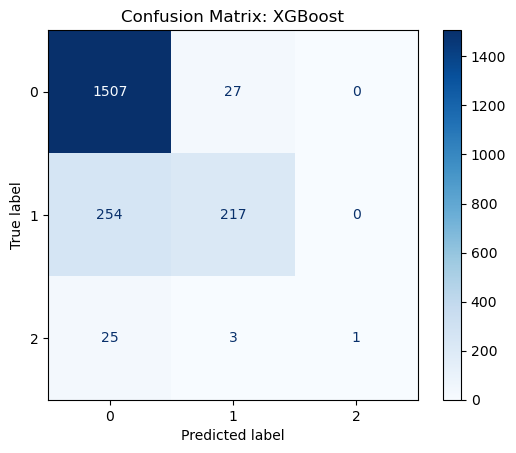

Model saved at: ml_model\ml_XGBoost_ChUnigram+ChTrigram.joblib

Evaluating MLPC-sgd...
Model Evaluation: MLPC-sgd
F1 Score: 0.83423 | Accuracy: 0.83530 | Precision: 0.83334 | Recall: 0.83530 | Training Accuracy: 0.93690 | Validation Accuracy: 0.83530


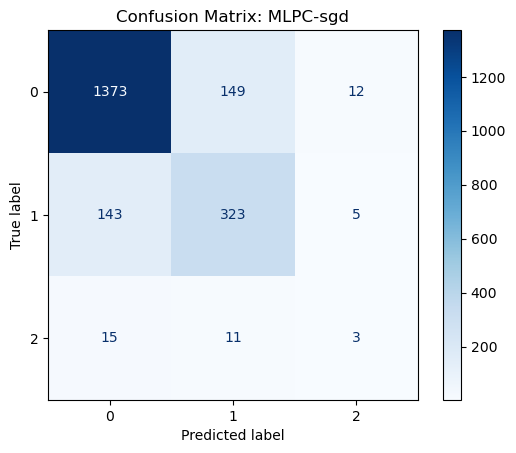

Model saved at: ml_model\ml_MLPC-sgd_ChUnigram+ChTrigram.joblib

Evaluating ExtraTreesC...
Model Evaluation: ExtraTreesC
F1 Score: 0.75711 | Accuracy: 0.80629 | Precision: 0.82811 | Recall: 0.80629 | Training Accuracy: 0.95380 | Validation Accuracy: 0.80629


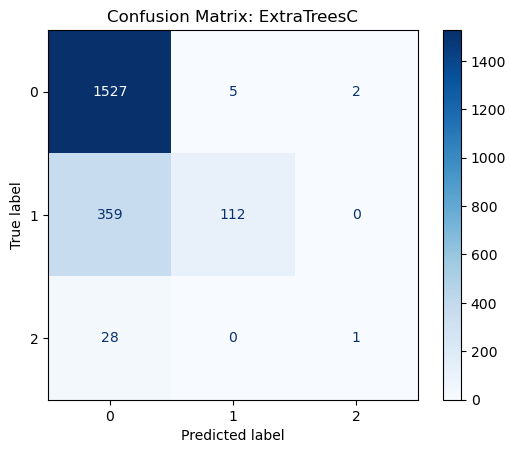

Model saved at: ml_model\ml_ExtraTreesC_ChUnigram+ChTrigram.joblib


In [89]:
df_CUCT_ml = evaluate_multiple_models(
    X_train_vec,X_test_vec,
    y_train_vec,y_test_vec,
    modelsAndNames,
    vectorization_method="ChUnigram+ChTrigram"
)

In [90]:
results_df = pd.concat([results_df, df_CUCT_ml], ignore_index=True)


ChUnigram+ChTrigram:
Epoch [1/50], Train Loss: 0.7080, Train Accuracy: 0.8556, Validation Loss: 1.5319, Validation Accuracy: 0.0143
Epoch [2/50], Train Loss: 0.6455, Train Accuracy: 0.9049, Validation Loss: 1.5372, Validation Accuracy: 0.0143
Epoch [3/50], Train Loss: 0.6288, Train Accuracy: 0.9220, Validation Loss: 1.5340, Validation Accuracy: 0.0167
Epoch [4/50], Train Loss: 0.6066, Train Accuracy: 0.9443, Validation Loss: 1.4573, Validation Accuracy: 0.0826
Epoch [5/50], Train Loss: 0.5991, Train Accuracy: 0.9518, Validation Loss: 1.4778, Validation Accuracy: 0.0659
Epoch [6/50], Train Loss: 0.5948, Train Accuracy: 0.9564, Validation Loss: 1.4650, Validation Accuracy: 0.0831
Epoch [7/50], Train Loss: 0.5936, Train Accuracy: 0.9577, Validation Loss: 1.3258, Validation Accuracy: 0.2237
Epoch [8/50], Train Loss: 0.5903, Train Accuracy: 0.9611, Validation Loss: 1.2669, Validation Accuracy: 0.2827
Epoch [9/50], Train Loss: 0.5876, Train Accuracy: 0.9636, Validation Loss: 1.4871, Validat

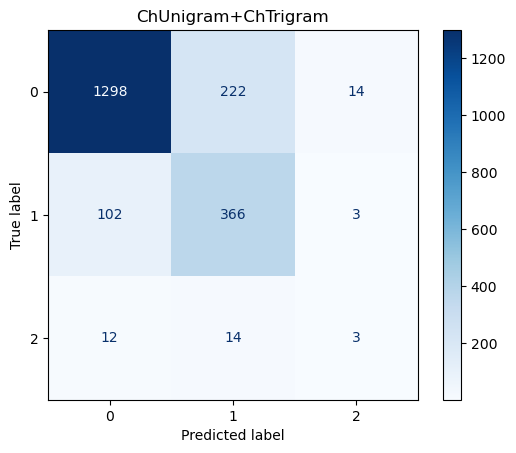

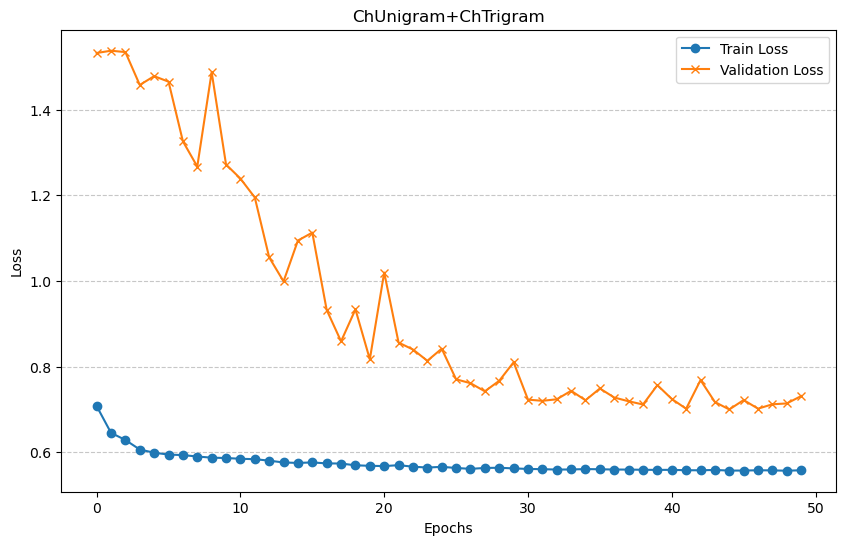

Model saved to models/ChUnigram+ChTrigram_ANN.pth
Results saved to models/ChUnigram+ChTrigram_results.csv
Model training completed successfully.
Model metric saved


In [91]:
try:
    df_CUCT = model_training( "ChUnigram+ChTrigram",
                               X_train_vec, X_test_vec,
                               y_train_vec, y_test_vec,
                               len_labels)

except Exception as e:
    print("An error occurred during model training:")
    print(e)
    clear_memory()

else:
    print("Model training completed successfully.")
    results_df = pd.concat([results_df, df_CUCT], ignore_index=True)
    print("Model metric saved")

In [92]:
clear_memory()

Cleared memory.
now memory used: 6534.34 MB


# Word Unigram + Word Bigram + Char Trigram -------------------------------------------

In [94]:
feature_union = FeatureUnion([
    ("word_unigram_count", word_unigram_count),
    ("word_unigram_tfidf", word_unigram_tfidf),

    ("char_bigram_count", char_bigram_count),
    ("char_bigram_tfidf", char_bigram_tfidf),

    ("char_trigram_count", char_trigram_count),
    ("char_trigram_tfidf", char_trigram_tfidf)

])

In [95]:
X_train_vec,X_test_vec,y_train_vec,y_test_vec = makeVector(feature_union,X_train,X_test,y_train,y_test)

y_train shape: (8135,)
First 10 feature names: ['word_unigram_count__00' 'word_unigram_count__000'
 'word_unigram_count__01' 'word_unigram_count__02'
 'word_unigram_count__03' 'word_unigram_count__04'
 'word_unigram_count__05' 'word_unigram_count__06'
 'word_unigram_count__07' 'word_unigram_count__08']
X_train_features shape: (8135, 39078)
X_test_features shape: (2034, 39078)
Before sampling Counter({0: 6133, 1: 1865, 2: 137})
After sampling Counter({0: 6133, 1: 6133, 2: 6133})
X_train shape: (18399, 39078),y_train shape: (18399,),



Evaluating CatBoostC...
Model Evaluation: CatBoostC
F1 Score: 0.73875 | Accuracy: 0.76401 | Precision: 0.73720 | Recall: 0.76401 | Training Accuracy: 0.82793 | Validation Accuracy: 0.76401


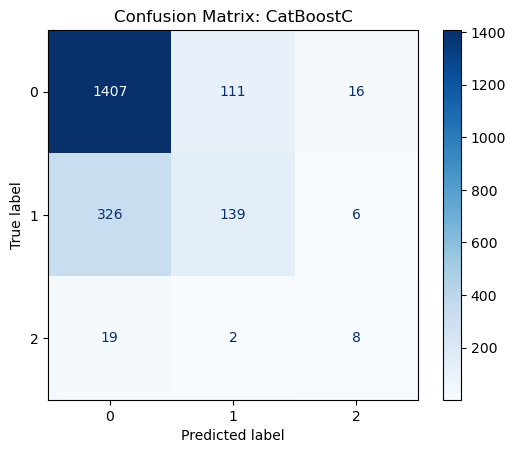

Model saved at: ml_model\ml_CatBoostC_WUniG+WBiG+ChTriG.joblib

Evaluating XGBoost...
Model Evaluation: XGBoost
F1 Score: 0.82176 | Accuracy: 0.84415 | Precision: 0.83269 | Recall: 0.84415 | Training Accuracy: 0.87787 | Validation Accuracy: 0.84415


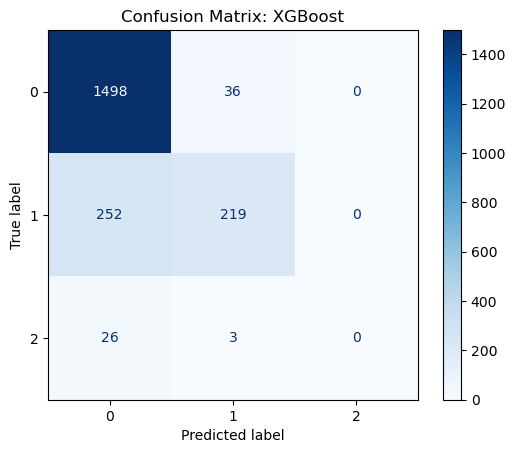

Model saved at: ml_model\ml_XGBoost_WUniG+WBiG+ChTriG.joblib

Evaluating MLPC-sgd...
Model Evaluation: MLPC-sgd
F1 Score: 0.83368 | Accuracy: 0.83038 | Precision: 0.83839 | Recall: 0.83038 | Training Accuracy: 0.93445 | Validation Accuracy: 0.83038


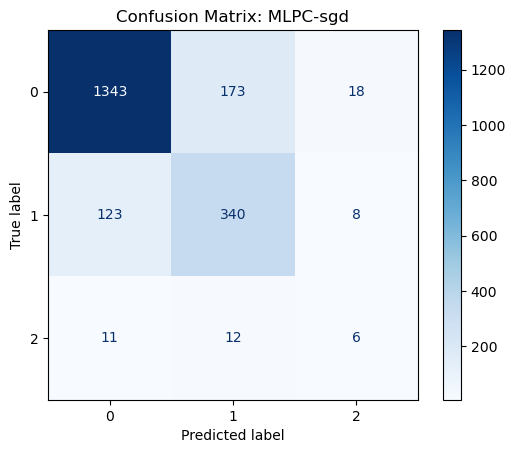

Model saved at: ml_model\ml_MLPC-sgd_WUniG+WBiG+ChTriG.joblib

Evaluating ExtraTreesC...
Model Evaluation: ExtraTreesC
F1 Score: 0.76626 | Accuracy: 0.81318 | Precision: 0.84698 | Recall: 0.81318 | Training Accuracy: 0.96016 | Validation Accuracy: 0.81318


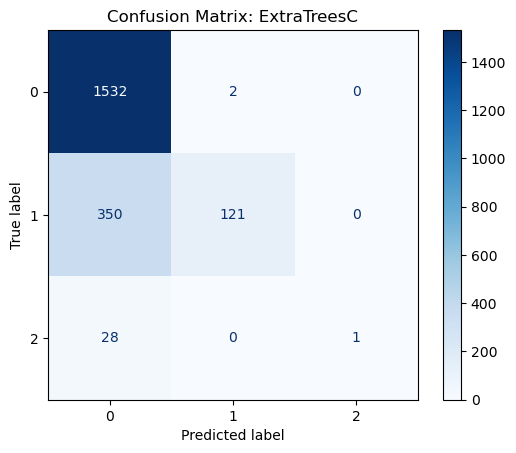

Model saved at: ml_model\ml_ExtraTreesC_WUniG+WBiG+ChTriG.joblib


In [96]:
df_WUWBCT_ml = evaluate_multiple_models(
    X_train_vec,X_test_vec,
    y_train_vec,y_test_vec,
    modelsAndNames,
    vectorization_method="WUniG+WBiG+ChTriG"
)

In [97]:
results_df = pd.concat([results_df, df_WUWBCT_ml], ignore_index=True)


WUniG+WBiG+ChTriG:
Epoch [1/50], Train Loss: 0.7335, Train Accuracy: 0.8181, Validation Loss: 1.5347, Validation Accuracy: 0.0147
Epoch [2/50], Train Loss: 0.6660, Train Accuracy: 0.8851, Validation Loss: 1.5372, Validation Accuracy: 0.0143
Epoch [3/50], Train Loss: 0.6745, Train Accuracy: 0.8756, Validation Loss: 1.5362, Validation Accuracy: 0.0143
Epoch [4/50], Train Loss: 0.6367, Train Accuracy: 0.9143, Validation Loss: 1.5303, Validation Accuracy: 0.0152
Epoch [5/50], Train Loss: 0.6361, Train Accuracy: 0.9144, Validation Loss: 1.4628, Validation Accuracy: 0.0742
Epoch [6/50], Train Loss: 0.6239, Train Accuracy: 0.9270, Validation Loss: 1.4286, Validation Accuracy: 0.1175
Epoch [7/50], Train Loss: 0.6156, Train Accuracy: 0.9356, Validation Loss: 1.4371, Validation Accuracy: 0.1234
Epoch [8/50], Train Loss: 0.6094, Train Accuracy: 0.9418, Validation Loss: 1.4795, Validation Accuracy: 0.0664
Epoch [9/50], Train Loss: 0.6181, Train Accuracy: 0.9330, Validation Loss: 1.4365, Validatio

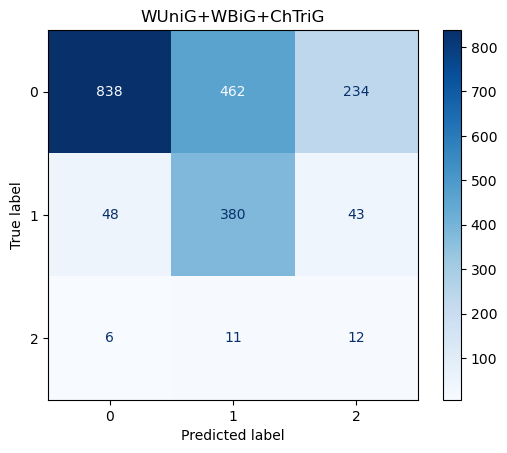

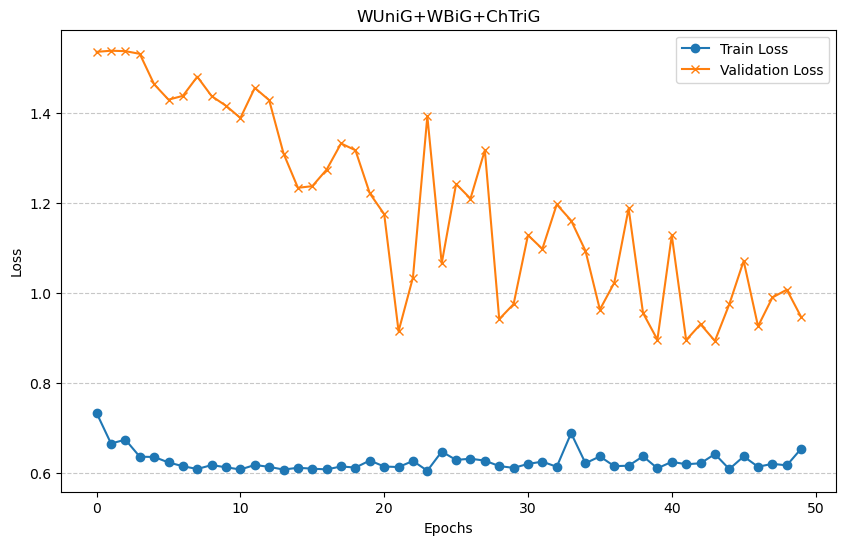

Model saved to models/WUniG+WBiG+ChTriG_ANN.pth
Results saved to models/WUniG+WBiG+ChTriG_results.csv
Model training completed successfully.
Model metric saved


In [98]:
try:
    df_WUWBCT = model_training( "WUniG+WBiG+ChTriG",
                               X_train_vec, X_test_vec,
                               y_train_vec, y_test_vec,
                               len_labels)

except Exception as e:
    print("An error occurred during model training:")
    print(e)
    clear_memory()

else:
    print("Model training completed successfully.")
    results_df = pd.concat([results_df, df_WUWBCT], ignore_index=True)
    print("Model metric saved")

In [99]:
clear_memory()

Cleared memory.
now memory used: 6931.89 MB


# Word Unigram + Word Bigram + Char Bigram + Char Trigram -------------------------------------------


In [101]:
feature_union = FeatureUnion([
    ("word_unigram_count", word_unigram_count),
    ("word_unigram_tfidf", word_unigram_tfidf),

    ("word_bigram_count", word_bigram_count),
    ("word_bigram_tfidf", word_bigram_tfidf),

    ("char_bigram_count", char_bigram_count),
    ("char_bigram_tfidf", char_bigram_tfidf),

    ("char_trigram_count", char_trigram_count),
    ("char_trigram_tfidf", char_trigram_tfidf)

])

In [102]:
X_train_vec,X_test_vec,y_train_vec,y_test_vec = makeVector(feature_union,X_train,X_test,y_train,y_test)

y_train shape: (8135,)
First 10 feature names: ['word_unigram_count__00' 'word_unigram_count__000'
 'word_unigram_count__01' 'word_unigram_count__02'
 'word_unigram_count__03' 'word_unigram_count__04'
 'word_unigram_count__05' 'word_unigram_count__06'
 'word_unigram_count__07' 'word_unigram_count__08']
X_train_features shape: (8135, 57078)
X_test_features shape: (2034, 57078)
Before sampling Counter({0: 6133, 1: 1865, 2: 137})
After sampling Counter({0: 6133, 1: 6133, 2: 6133})
X_train shape: (18399, 57078),y_train shape: (18399,),



Evaluating CatBoostC...
Model Evaluation: CatBoostC
F1 Score: 0.73819 | Accuracy: 0.76745 | Precision: 0.73891 | Recall: 0.76745 | Training Accuracy: 0.82651 | Validation Accuracy: 0.76745


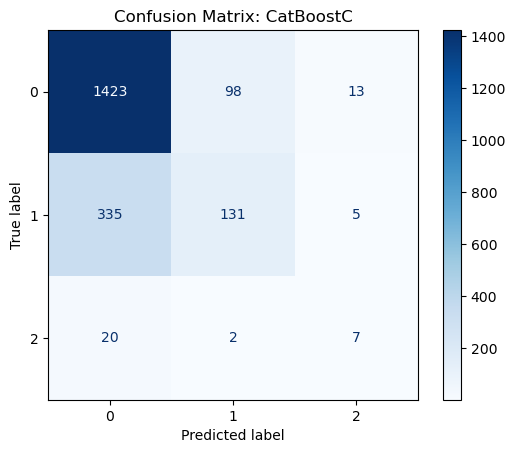

Model saved at: ml_model\ml_CatBoostC_WUniG+WBiG+ChBiG+ChTriG.joblib

Evaluating XGBoost...
Model Evaluation: XGBoost
F1 Score: 0.81892 | Accuracy: 0.84071 | Precision: 0.82640 | Recall: 0.84071 | Training Accuracy: 0.87836 | Validation Accuracy: 0.84071


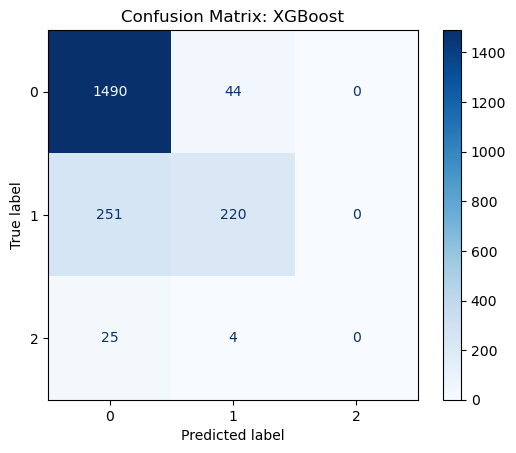

Model saved at: ml_model\ml_XGBoost_WUniG+WBiG+ChBiG+ChTriG.joblib

Evaluating MLPC-sgd...
Model Evaluation: MLPC-sgd
F1 Score: 0.83127 | Accuracy: 0.83038 | Precision: 0.83235 | Recall: 0.83038 | Training Accuracy: 0.93076 | Validation Accuracy: 0.83038


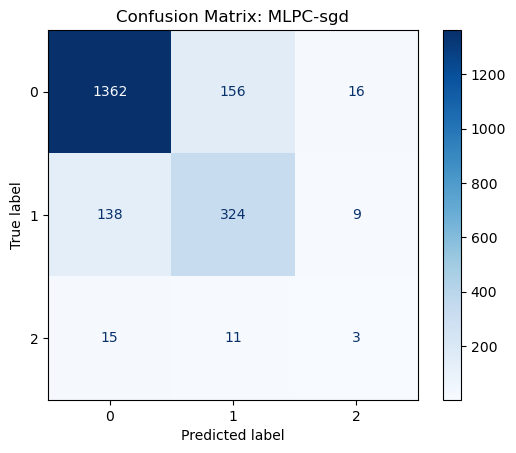

Model saved at: ml_model\ml_MLPC-sgd_WUniG+WBiG+ChBiG+ChTriG.joblib

Evaluating ExtraTreesC...
Model Evaluation: ExtraTreesC
F1 Score: 0.76228 | Accuracy: 0.80924 | Precision: 0.82154 | Recall: 0.80924 | Training Accuracy: 0.95842 | Validation Accuracy: 0.80924


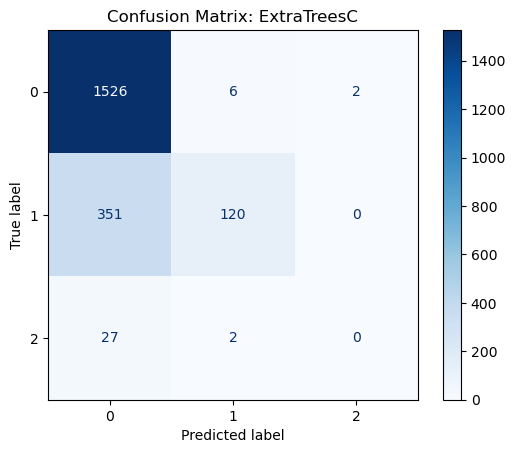

Model saved at: ml_model\ml_ExtraTreesC_WUniG+WBiG+ChBiG+ChTriG.joblib


In [103]:
df_WUWBCBCT_ml = evaluate_multiple_models(
    X_train_vec,X_test_vec,
    y_train_vec,y_test_vec,
    modelsAndNames,
    vectorization_method="WUniG+WBiG+ChBiG+ChTriG"
)

In [104]:
results_df = pd.concat([results_df, df_WUWBCBCT_ml], ignore_index=True)


WUniG+WBiG+ChBiG+ChTriG:
Epoch [1/50], Train Loss: 0.6987, Train Accuracy: 0.8531, Validation Loss: 1.5371, Validation Accuracy: 0.0143
Epoch [2/50], Train Loss: 0.6538, Train Accuracy: 0.8952, Validation Loss: 1.5322, Validation Accuracy: 0.0177
Epoch [3/50], Train Loss: 0.6584, Train Accuracy: 0.8926, Validation Loss: 1.4741, Validation Accuracy: 0.0742
Epoch [4/50], Train Loss: 0.6318, Train Accuracy: 0.9193, Validation Loss: 1.4804, Validation Accuracy: 0.0698
Epoch [5/50], Train Loss: 0.6312, Train Accuracy: 0.9200, Validation Loss: 1.5028, Validation Accuracy: 0.0482
Epoch [6/50], Train Loss: 0.6405, Train Accuracy: 0.9105, Validation Loss: 1.3596, Validation Accuracy: 0.1893
Epoch [7/50], Train Loss: 0.6527, Train Accuracy: 0.8984, Validation Loss: 1.4936, Validation Accuracy: 0.0565
Epoch [8/50], Train Loss: 0.6383, Train Accuracy: 0.9129, Validation Loss: 1.5220, Validation Accuracy: 0.0295
Epoch [9/50], Train Loss: 0.6308, Train Accuracy: 0.9205, Validation Loss: 1.3838, Val

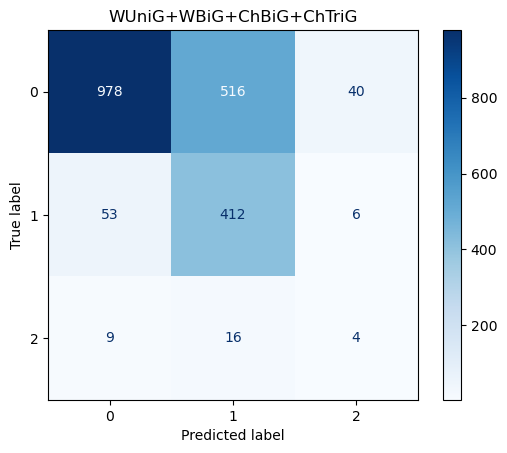

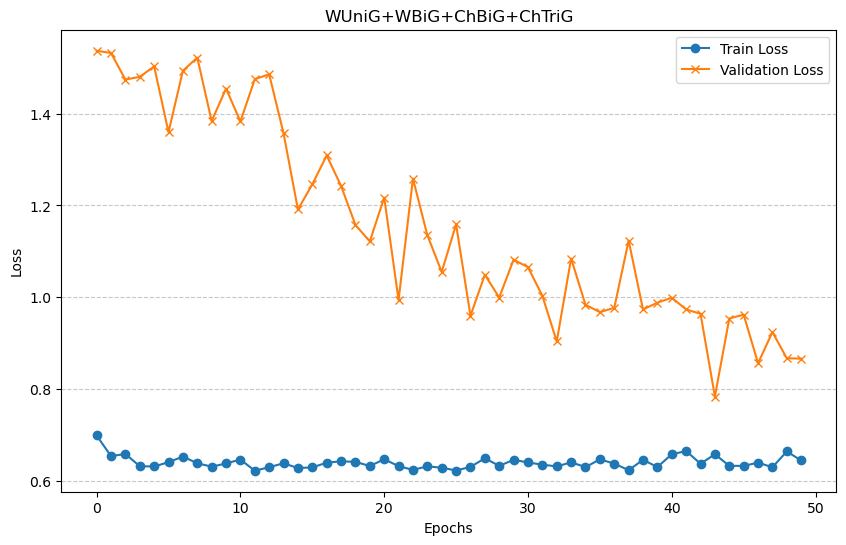

Model saved to models/WUniG+WBiG+ChBiG+ChTriG_ANN.pth
Results saved to models/WUniG+WBiG+ChBiG+ChTriG_results.csv
Model training completed successfully.
Model metric saved


In [105]:
try:
    df_WUWBCBCT = model_training( "WUniG+WBiG+ChBiG+ChTriG",
                               X_train_vec, X_test_vec,
                               y_train_vec, y_test_vec,
                               len_labels)

except Exception as e:
    print("An error occurred during model training:")
    print(e)
    clear_memory()

else:
    print("Model training completed successfully.")
    results_df = pd.concat([results_df, df_WUWBCBCT], ignore_index=True)
    print("Model metric saved")

In [106]:
clear_memory()

Cleared memory.
now memory used: 12814.32 MB


# 🐋Consequence🐳

In [108]:
results_df

,Model,Vectorization Method,Accuracy,Precision,Recall,F1 Score
0,CatBoostC,TurkishWord2Vec,0.629794,0.716249,0.629794,0.664940
1,XGBoost,TurkishWord2Vec,0.766962,0.749744,0.766962,0.757297
2,MLPC-sgd,TurkishWord2Vec,0.725664,0.767823,0.725664,0.741140
3,ExtraTreesC,TurkishWord2Vec,0.770403,0.730594,0.770403,0.735169
4,ANN,TurkishWord2Vec,0.161259,0.771834,0.161259,0.249338
5,CatBoostC,FineTuneWord2Vec,0.538348,0.672612,0.538348,0.590817
6,XGBoost,FineTuneWord2Vec,0.721239,0.700948,0.721239,0.709300
7,MLPC-sgd,FineTuneWord2Vec,0.301868,0.650208,0.301868,0.379265
8,ExtraTreesC,FineTuneWord2Vec,0.752212,0.698773,0.752212,0.702753
9,ANN,FineTuneWord2Vec,0.236480,0.700203,0.236480,0.098889


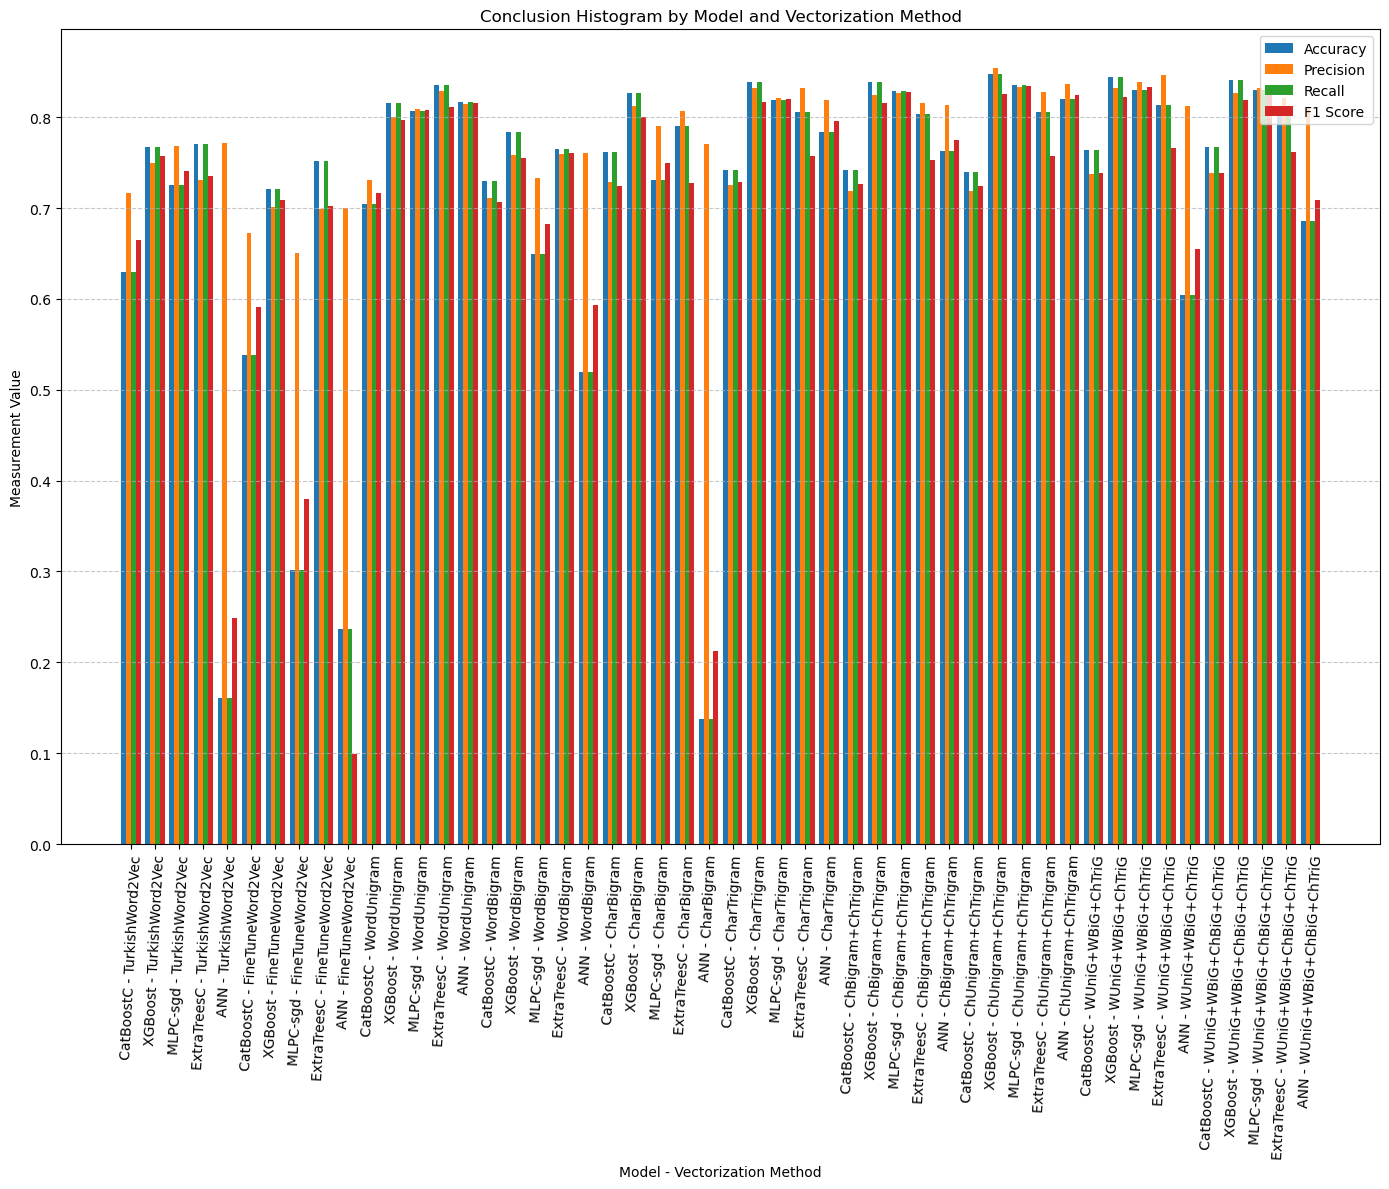

In [109]:
plot_conclusion(results_df, rotate_xticks=87)

In [110]:
results_df.to_csv("eval.csv", index=False)